In [19]:
Full={}
Full_f={}
Full_f1={}
max_kin=2

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import glob
import numpy as np
import scipy
from scipy import interpolate
sys.path.append('/home/jbane/headers')
import SQLFuncs as SQLF


plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12


def Cross_table(tgt,table):
   
    #Fill the table once
    if len(table) != 10:
        for i in range(16):
            file_name = "/home/jbane/tritium/T2_externals/OUT/marathon_kin{}_{}.out".format(i,tgt)
            #file_name = "/home/jbane/tritium/extern/T2_externals/OUT/marathon_kin{}_{}.out".format(i,tgt)
           # print(file_name)
            if os.path.isfile(file_name):
                table[i] = pd.read_table(file_name,delim_whitespace=True)
                
                
def interper(DFs,x,Q):
    f = interpolate.interp2d(DFs["x"],DFs["Q2"],DFs["Sig_Born"],kind='linear', copy=True,  bounds_error=True)
    sigma_born=f(x,Q)
    h = interpolate.interp2d(DFs["x"],DFs["Q2"],DFs["Sig_Rad"],kind='linear', copy=True, bounds_error=True )
    sigma_rad=h(x,Q)
    return sigma_born,sigma_rad  

def weighted_average(df,data_col,weight_col,by_col):
    df['_data_times_weight'] = df[data_col]*df[weight_col]
    df['_weight_where_notnull'] = df[weight_col]*pd.notnull(df[data_col])
    g = df.groupby(by_col)
    result = g['_data_times_weight'].sum() / g['_weight_where_notnull'].sum()
    del df['_data_times_weight'], df['_weight_where_notnull']
    return result

def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()



In [39]:
cuttype="tightcut/"

def all_tgt(tgt,bins):

    table={}
    Cross_table(tgt,table)
    
    Xaxis="Xbj" #theta / Xbj
    if Xaxis == "Xbj":
        xaxis="xbj"
    else :
        xaxis="theta"

    mcfile='/home/jbane/tritium/Tri_offline/MC_comparison/yield_output/{}{}bins/{}/'.format(cuttype,bins,xaxis)
    datafile='/home/jbane/tritium/Tri_offline/yield/yield_output/{}{}bins/{}/'.format(cuttype,bins,xaxis)
    kins={}
    kin={}
    sig_r={}
    sig_b={}
    sig_rr={}
    sig_bb={}

    kins=sorted(glob.glob('{}{}_kin?.dat'.format(mcfile,tgt)))
    kins+=sorted(glob.glob('{}{}_kin??.dat'.format(mcfile,tgt)))

    kin_num_array={}

    mcDF={}
    dataDF={}
    mcDFs={}
    dataDFs={}
    ratios={}
    i=0
    for i in range(len(kins)):
        kin[i] = kins[i].replace(mcfile,"")
        kin[i] = kin[i].replace('.dat',"")

        
        kin_str_num=kin[i].replace("{}_kin".format(tgt),"")
        kin_num=int(kin_str_num)
 
        if kin_num > max_kin :
            continue
        
        
        kin_str_num=kin[i].replace("{}_kin".format(tgt),"")
        kin_num=int(kin_str_num)   
        kin_num_array[i]=kin_num
        mcfileR=mcfile+'{}.dat'.format(kin[i])
        datafileR=datafile+'{}.dat'.format(kin[i])
        chk1=0
        chk=0
        if os.path.isfile(mcfileR):
            chk=1
        else:
            ("MC file does not exist") 
            chk=0
        if os.path.isfile(datafileR):
            chk1=1
        else :
            print("Data file does not exist")
            chk1=0
        if chk==0 or chk1==0:
            mcDF[i]=pd.DataFrame()
            dataDF[i]=pd.DataFrame()
            continue     

        mcDF[i]=pd.read_table(mcfileR,delim_whitespace=True)
        dataDF[i]=pd.read_table(datafileR,delim_whitespace=True)
        mcDF[i]['yield']=mcDF[i]['Yield']/1000.0
        mcDF[i]['Error']=mcDF[i]['Error']/1000.0

        dataDF[i]['yield']=dataDF[i]['Yield']
        mcmed=mcDF[i]['yield'].mean()
        datamed=dataDF[i]['yield'].mean()
        mcDFs[i]=mcDF[i][mcDF[i]['yield'] >=mcmed *0.5]
        dataDFs[i]=dataDF[i][dataDF[i]['yield'] >= datamed *0.5]
        mcDFs[i]=mcDFs[i].dropna()
        dataDFs[i]=dataDFs[i].dropna()
   
        if len(dataDFs[i]) <2 :
                continue
        #cut out the edge bins for now
        dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
        last= len(dataDFs[i].index)
        #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[last-1])
        
        mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[0])
        ml=len(mcDFs[i].index)
        #mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[ml-1])

        minind= dataDFs[i].index[0]
        maxind=dataDFs[i].index[len(dataDFs[i].index)-1]
        mcDFs[i]=mcDFs[i][mcDFs[i].index>=minind]
       # mcDFs[i]=mcDFs[i][mcDFs[i].index<=maxind]        
        if len(dataDFs[i]) >=6 :
            dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
            last= len(dataDFs[i].index)
            dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[last-1])
            mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[0])
            ml=len(mcDFs[i].index)
            mcDFs[i]=mcDFs[i].drop(mcDFs[i].index[ml-1])

            
            
    #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[0])
    #dataDFs[i]=dataDFs[i].drop(dataDFs[i].index[last-2])
    

       # print("data",i, dataDFs[i])
       # print("MC  ",i,mcDFs[i])
        #dataDFs[i]= dataDFs[i].drop(dataDFs[i].index[[0,len(dataDFs[i])-1]])
        #mcDFs[i]=     mcDFs[i].drop(mcDFs[i].index[  [0,  len(mcDFs[i])-1]])
        dataDFs[i]['Stat_err']=1.0/np.sqrt((dataDFs[i]['Ne']))*dataDFs[i]['yield']
        ratios[i] = mcDFs[i].copy()
        ratios[i].rename(columns={'Ne':'MC_Ne'})
        ratios[i]['Data_Ne']=dataDFs[i]['Ne']
        #ratios[i].drop('yield')
        ratios[i]["data_err"]=dataDFs[i]['Error']
        ratios[i]["data_err_stat"]=dataDFs[i]['Stat_err']
        ratios[i]['data_Y'] =dataDFs[i]['yield']
        ratios[i]['MC_Y'] = mcDFs[i]['yield']
        ratios[i]['ratio'] = dataDFs[i]['yield']/mcDFs[i]['yield']
        ratios[i]['offset'] = dataDFs[i]['yield'] - mcDFs[i]['yield']
        ratios[i]['ratio_err'] =ratios[i]['ratio']*np.sqrt(  pow((dataDFs[i]['Error']/dataDFs[i]['yield']),2) + pow((mcDFs[i]['Error']/mcDFs[i]['yield']),2))
        ratios[i]['new_x'] = -ratios[i]['{}'.format(Xaxis)].mean()+ratios[i]['{}'.format(Xaxis)]    
            
            #pow((1/(np.sqrt(dataDFs[i]['Ne']))),2)  +   pow((1/(np.sqrt(mcDFs[i]['Ne']))),2)     )

        i=i+1

    import matplotlib._color_data as mcd
    overlap = [name for name in mcd.CSS4_COLORS if "xkcd:" + name in mcd.XKCD_COLORS]

    markers =[[3,0,0]  ,[5,1,90] ,[4,0,90],[3,1,90],[6,2,0] ,[5,0,0] ,[4,1,0],[7,0,0]]
    markers2 =[[3,0,0] ,[5,1,90] ,[4,0,90],[3,1,90],[6,2,0] ,[5,0,0],[4,1,0],[7,0,0]]
    colors=['red', 'Green', 'Blue', 'Orange', 'Purple', 'Cyan', 'Magenta','Teal','Brown','Maroon','Mint','Navy',]
    fig= plt.figure(dpi=500,figsize=(7,5))
    ax=fig.add_subplot(2,1,1)
    plt.title('{} Data to MC comparison'.format(tgt))
    bx=fig.add_subplot(2,1,2, sharex=ax)

    #fig,bx=plt.subplots(dpi=250)
    k=int(0)

    print("start second loop")
    for j in range(len(mcDF)):
        
        xkcd = mcd.XKCD_COLORS["xkcd:" + overlap[j]].upper()
        xkcd2 = mcd.XKCD_COLORS["xkcd:" + overlap[j+len(mcDF)]].upper()
        #print(j , kin[j])
        #print()
        if k == 7:
            k = 0
        if dataDF[j].empty or mcDF[j].empty:
            continue
        if(len(dataDFs[j])) == 0:
            continue
        if(len(mcDF[j])) ==0:
            continue



        kin_str_num=kin[j].replace("{}_kin".format(tgt),"")
        kin_num=int(kin_str_num)
        print(kin_num)
        if kin_num > max_kin :
            continue
        xbj=ratios[j]["Xbj"]
        Q2=ratios[j]["Q2"]
     #   print( xbj,Q2)
        sig_bb[kin_num],sig_rr[kin_num] =interper(table[kin_num],xbj,Q2)
        print()
        print(sig_bb[kin_num])
        print()
        if len(sig_bb[kin_num]) > 1:
            sig_b[kin_num]=sig_bb[kin_num].diagonal()
        else:
            sig_b[kin_num]=sig_bb[kin_num]
        if len(sig_rr[kin_num]) > 1:
            sig_r[kin_num]=sig_rr[kin_num].diagonal()
        else:
            sig_r[kin_num]=sig_rr[kin_num]
        ratios[j]["Sigma_Born"]=sig_b[kin_num]
        ratios[j]["Sigma_Rad"]=sig_r[kin_num]
        ratios[j]["RCF"] =ratios[j]["Sigma_Born"]/ ratios[j]["Sigma_Rad"]
        ratios[j]["Sigma_Born_C"]=ratios[j]["Sigma_Born"]*ratios[j]["ratio"]
        ratios[j]["Sigma_Rad_C"]=ratios[j]["Sigma_Rad"]*ratios[j]["ratio"]
        ratios[j]["Sig_Born_err"]=ratios[j]["Sigma_Born"]* np.sqrt( pow( (ratios[j]['ratio_err']/ratios[j]["ratio"] ),2) )
        ratios[j]["Sig_Rad_err"]=ratios[j]["Sigma_Rad"]  * np.sqrt( pow( (ratios[j]['ratio_err']/ratios[j]["ratio"] ),2) )




     #   print(sig_b[kin_num])
     #   print(sig_r[kin_num])    
        #if j == 110:
         #   ax = mcDFs[j].plot(x='theta',y='yield',yerr=':error',kind='scatter', marker=markers[j], color='blue', label='MC run{}'.format(runs[j]))
        #else :
        if k == 0:
            mcDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Error',kind='scatter',marker=markers[k], color='blue', label='Monte Carlo')
            dataDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Error',kind='scatter', marker=markers2[k], color='red', label='Data ')
            dataDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Stat_err',kind='scatter', marker=markers2[k], color='red')
        else :
            mcDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Error',kind='scatter',marker=markers[k], color='blue')
            dataDFs[j].plot(ax=ax,x='{}'.format(Xaxis),y='yield',yerr='Error',kind='scatter', marker=markers2[k], color='red')
            
        ratios[j].plot(ax=bx,x='{}'.format(Xaxis) ,y='ratio',yerr='ratio_err', xerr='offset', kind='scatter', label='{}'.format(kin[j]),marker=markers2[k],c=colors[k] )
        k=k+1
        print(j , kin[j])    



        
      
    ax.set_yscale("log")
    ax.grid(True)
    bx.grid(True)
    
    
    ax.legend(ncol=4)

    handles, labels = ax.get_legend_handles_labels()
    print(handles,labels)
    
    #ax.get_legend().remove()
    
    if tgt == "H":
        bx.legend(ncol=2)
    else :
        bx.legend(ncol=3)    
    #bx.set_ylim(0.7,1.2)

    
   # fig.text(0.5, 0.5, 'Preliminary',
   #      fontsize=75, color='gray',
   #      ha='center', va='center', alpha=0.5)
    
    fig.subplots_adjust(hspace=0)
    fig.savefig('images/{}{}bins/{}_all.png'.format(cuttype,bins,tgt),bbox_inches='tight')
    fig.savefig('images/{}{}bins/{}_all.pdf'.format(cuttype,bins,tgt),bbox_inches='tight')
    fig.savefig('images/{}{}bins/{}_all.eps'.format(cuttype,bins,tgt),bbox_inches='tight')
    fig.savefig('/home/jbane/latex_shows/images/{}_all.pdf'.format(tgt),bbox_inches='tight')

  
    return ratios,kin,fig


In [31]:

def all_plots(Full,bins):
    D2=Full[0]
    He3=Full[1]
    H3=Full[2]

    fig3= plt.figure(dpi=400,figsize=(11,5))
    cx=fig3.add_subplot(1,1,1)
    plt.title('Coss Section by Monte Carlo Ratio')
    D2.plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",label="D2")
    He3.plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",color='r',marker='+',label="He3")
    H3.plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",color='g',marker="x",label="H3")
    cx.set_yscale("log")
    plt.ylabel('$\sigma $ ')
    cx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig3.savefig('images/{}{}bins/all_final.png'.format(cuttype,bins),bbox_inches='tight')
    return D2, He3, H3

def EMC(D2,He3,H3,bins):

    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )

    fig4= plt.figure(dpi=500,figsize=(11,5))
    dx=fig4.add_subplot(1,1,1)
    plt.title('Cross section ratio ')

    EMC_He3.plot(ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    
    
    #Add in He3 datamined data
    He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="He3/D E3103")
    
    
    #dx.set_yscale("log")
    dx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    dx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig4.savefig('images/{}{}bins/EMC_final.png'.format(cuttype,bins),bbox_inches='tight')

    
def ISO_EMC(D2,He3,H3,bins):  
    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False) 

        

    He3df_cor_mined = pd.read_csv("/home/jbane/Downloads/corrected.csv",names=['xbj','EMC'])
    He3df_uncor_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    
    fn_fp_r = He3df_cor_mined
    fn_fp_r['Fn/Fp']=  He3df_uncor_mined['EMC']/ He3df_cor_mined['EMC']
    fun_fn_fp = interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True , bounds_error=False)
    

    
    EMC_H3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_H3['Xbj'])))/((1/3.0)*(1+2*F_n_p(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_He3['Xbj'])))/((1/3.0)*(2+1*F_n_p(EMC_He3['Xbj'])))
    EMC_H3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*fun_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*fun_fn_fp(EMC_He3['Xbj'])))
    
    EMC_H3['Iso_EMC'] =EMC_H3['EMC']*EMC_H3['Iso_fac']
    EMC_He3['Iso_EMC'] =EMC_He3['EMC']*EMC_He3['Iso_fac']
    
    EMC_H3['Iso_EMC_E3'] =EMC_H3['EMC']*EMC_H3['Iso_fac_E3']
    EMC_He3['Iso_EMC_E3'] =EMC_He3['EMC']*EMC_He3['Iso_fac_E3']
    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="E3103_uncorrected")
    fig5= plt.figure(dpi=500,figsize=(11,5))
    hx=fig5.add_subplot(1,1,1)
    plt.title('Cross section ratio Isoscalar corrected')
    
    
    #E3103
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='r',marker='P',label="He3/D E3")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='g',marker="p",label="H3/D E3")
    
    He3df_cor_mined.plot(ax=hx,x='xbj',y='EMC',color='c',marker='H',label="He3 E3103")

    hx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    hx.grid(True)

    
def EMC(D2,He3,H3,bins):

    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )

    fig4= plt.figure(dpi=500,figsize=(11,5))
    dx=fig4.add_subplot(1,1,1)
    plt.title('Cross section ratio ')

    EMC_He3.plot(ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=dx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    
    
    #Add in He3 datamined data
    He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="He3/D E3103")
    
    
    #dx.set_yscale("log")
    dx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    dx.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig4.savefig('images/{}{}bins/EMC_final.png'.format(cuttype,bins),bbox_inches='tight')

    
def ISO_EMC(D2,He3,H3,bins):  
    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False) 

        

    He3df_cor_mined = pd.read_csv("/home/jbane/Downloads/corrected.csv",names=['xbj','EMC'])
    He3df_uncor_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    
    fn_fp_r = He3df_cor_mined
    fn_fp_r['Fn/Fp']=  He3df_uncor_mined['EMC']/ He3df_cor_mined['EMC']
    fun_fn_fp = interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True , bounds_error=False)
    

    
    EMC_H3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_H3['Xbj'])))/((1/3.0)*(1+2*F_n_p(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_He3['Xbj'])))/((1/3.0)*(2+1*F_n_p(EMC_He3['Xbj'])))
    EMC_H3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*fun_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*fun_fn_fp(EMC_He3['Xbj'])))
    
    EMC_H3['Iso_EMC'] =EMC_H3['EMC']*EMC_H3['Iso_fac']
    EMC_He3['Iso_EMC'] =EMC_He3['EMC']*EMC_He3['Iso_fac']
    
    EMC_H3['Iso_EMC_E3'] =EMC_H3['EMC']*EMC_H3['Iso_fac_E3']
    EMC_He3['Iso_EMC_E3'] =EMC_He3['EMC']*EMC_He3['Iso_fac_E3']
    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="E3103_uncorrected")
    fig5= plt.figure(dpi=500,figsize=(11,5))
    hx=fig5.add_subplot(1,1,1)
    plt.title('Cross section ratio Isoscalar corrected')
    
    
    #E3103
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D ")
    EMC_He3.plot(ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='r',marker='P',label="He3/D E3")
    EMC_H3.plot( ax=hx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='g',marker="p",label="H3/D E3")
    
    He3df_cor_mined.plot(ax=hx,x='xbj',y='EMC',color='c',marker='H',label="He3 E3103")

    hx.set_ylim(0.75,1.2)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    hx.grid(True)
    
    
def ISO_EMC_both(D2,He3,H3,bins):  
    H3_s=H3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    He3_s=He3[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_H3  = pd.concat([D2_s,H3_s], axis=1)
    EMC_He3 = pd.concat([D2_s,He3_s],axis=1)

    EMC_H3 =EMC_H3.dropna()
    EMC_He3=EMC_He3.dropna()

    EMC_H3['EMC']  = ( EMC_H3['Sigma_Born_C']/ EMC_H3['D2_Born']) * (2/3) 
    EMC_H3['offset'] = abs(EMC_H3['Xbj'] - EMC_H3['D2_Xbj'])
    EMC_H3['EMC_err'] = EMC_H3['EMC'] * np.sqrt( pow( (EMC_H3['Sig_Born_err']/EMC_H3['Sigma_Born_C']),2) + pow( (EMC_H3['D2_err']/EMC_H3['D2_Born']),2) )

    EMC_He3['EMC'] = (EMC_He3['Sigma_Born_C']/EMC_He3['D2_Born']) * (2/3)
    EMC_He3['offset'] = abs(EMC_He3['Xbj'] - EMC_He3['D2_Xbj'])
    EMC_He3['EMC_err'] = EMC_He3['EMC'] * np.sqrt( pow( (EMC_He3['Sig_Born_err']/EMC_He3['Sigma_Born_C']),2) + pow( (EMC_He3['D2_err']/EMC_He3['D2_Born']),2) )
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False) 

        

    He3df_cor_mined = pd.read_csv("/home/jbane/Downloads/corrected.csv",names=['xbj','EMC'])
    He3df_uncor_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    
    fn_fp_r = He3df_cor_mined
    fn_fp_r['Fn/Fp']=  He3df_uncor_mined['EMC']/ He3df_cor_mined['EMC']
    fun_fn_fp = interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True , bounds_error=False)
    
    #p=[0.9377,-1.224,0.7604]
    p=[1.019,-1.317,0.8194]
    
    function_fn_fp= lambda x: x**2*p[2] + x*p[1] + p[0]
       
    EMC_H3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_H3['Xbj'])))/((1/3.0)*(1+2*F_n_p(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_He3['Xbj'])))/((1/3.0)*(2+1*F_n_p(EMC_He3['Xbj'])))
    EMC_H3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*fun_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_E3'] = (0.5*(1.0 + fun_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*fun_fn_fp(EMC_He3['Xbj'])))

    EMC_H3['Iso_fac_tong'] = (0.5*(1.0 + function_fn_fp(EMC_H3['Xbj'])))/((1/3.0)*(1+2*function_fn_fp(EMC_H3['Xbj'])))
    EMC_He3['Iso_fac_tong'] = (0.5*(1.0 + function_fn_fp(EMC_He3['Xbj'])))/((1/3.0)*(2+1*function_fn_fp(EMC_He3['Xbj'])))
   
    EMC_H3['Iso_EMC'] =EMC_H3['EMC']*EMC_H3['Iso_fac']
    EMC_He3['Iso_EMC'] =EMC_He3['EMC']*EMC_He3['Iso_fac']

    EMC_H3['Iso_EMC_E3'] =EMC_H3['EMC']*EMC_H3['Iso_fac_E3']
    EMC_He3['Iso_EMC_E3'] =EMC_He3['EMC']*EMC_He3['Iso_fac_E3']

    EMC_H3['Iso_EMC_tong'] =EMC_H3['EMC']*EMC_H3['Iso_fac_tong']
    EMC_He3['Iso_EMC_tong'] =EMC_He3['EMC']*EMC_He3['Iso_fac_tong']

    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="E3103_uncorrected")
    fig5= plt.figure(dpi=500,figsize=(11,9))
    fx=plt.subplot(2,1,1)
    fx.set(ylabel='($\sigma_A /3)  / (\sigma_D /2) $ ')
    #plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    
    plt.title('Cross section ratio Isoscalar corrected')
    
    gx=plt.subplot(2,1,2, sharex=fx, sharey=fx) 
   #gx.set(ylabel='($\sigma_A /3)  / (\sigma_D /2) $ ')
    #E3103

    #EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="Iso_EMC_E3",yerr='EMC_err',kind="scatter",color='m',marker='*',label="He3/D Iso E3")
    EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="Iso_EMC_tong",yerr='EMC_err',kind="scatter",color='k',marker='D',label="He3/D Iso Tong")
    EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker='p',label="He3/D")
    EMC_He3.plot(ax=fx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='r',marker='+',label="He3/D Iso")

    EMC_H3.plot( ax=gx,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="H3/D Iso")
    EMC_H3.plot( ax=gx,x="Xbj",xerr='offset',y="Iso_EMC_tong",yerr='EMC_err',kind="scatter",color='k',marker="D",label="H3/D Iso Tong")
    EMC_H3.plot( ax=gx,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='b',marker="p",label="H3/D ")
    
    He3df_cor_mined.plot(ax=fx,x='xbj',y='EMC',color='m',marker='h',label="He3 E3103 cor")
    He3df_uncor_mined.plot(ax=fx,x='xbj',y='EMC',color='c',marker='h',label="He3 E3103 uncor")
    fx.set_ylim(0.75,1.2)
    fx.set_ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    fx.grid(True)    

    gx.set_ylim(0.7,1.1)
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    gx.grid(True)    
    fig5.subplots_adjust(hspace=0)
    fig5.savefig('images/{}{}bins/EMC_iso_final.png'.format(cuttype,bins),bbox_inches='tight')
    
    
    
def EMC_one(A,tgt_name,A_num,D2,bins):

    A_s=A[['Xbj','Sigma_Born_C','Sig_Born_err']]
    
    D2_s=D2[['Xbj','Sigma_Born_C','Sig_Born_err']]
    D2_s=D2_s.rename(columns={"Xbj":"D2_Xbj","Sigma_Born_C": "D2_Born", "Sig_Born_err": "D2_err"})

    EMC_A  = pd.concat([D2_s,A_s], axis=1)
    
    EMC_A =EMC_A.dropna()
    
    EMC_A['EMC']  = ( EMC_A['Sigma_Born_C']/ EMC_A['D2_Born']) * (2/(A_num*1.0)) 
    EMC_A['offset'] = abs(EMC_A['Xbj'] - EMC_A['D2_Xbj'])
    EMC_A['EMC_err'] = EMC_A['EMC'] * np.sqrt( pow( (EMC_A['Sig_Born_err']/EMC_A['Sigma_Born_C']),2) + pow( (EMC_A['D2_err']/EMC_A['D2_Born']),2) )

    fig= plt.figure(dpi=500,figsize=(11,5))
    x=fig.add_subplot(1,1,1)
    plt.title('Cross section ratio ')

    EMC_A.plot( ax=x,x="Xbj",xerr='offset',y="EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="{}/D ".format(tgt_name))
    
    
    #Add in He3 datamined data
    #He3df_un_mined = pd.read_csv("/home/jbane/Downloads/uncorrected.csv",names=['xbj','EMC'])
    #He3df_un_mined.plot(ax=dx,x='xbj',y='EMC',color='b',marker='D',label="He3/D E3103")
    
    
    #dx.set_yscale("log")
    x.set_ylim(0.75,1.2)    
    plt.ylabel('($\sigma_A /3)  / (\sigma_D /2) $ ')
    x.grid(True)

    #fig1.subplots_adjust(hspace=0)
    fig.savefig('images/{}{}bins/EMC_{}.png'.format(cuttype,bins,tgt_name),bbox_inches='tight')
    return EMC_A

def ISO_Cor_EMC(EMC_A,tgt_name,A_num,Z_num,bins):
    
    #fig= plt.figure(dpi=500,figsize=(11,9))
    #plt.title('Cross section ratio Isoscalar corrected')
    #x=fig.add_subplot(1,1,1)
    
    
    Fn_Fp= pd.read_csv("/home/jbane/Downloads/Fn_Fp.csv")
    F_n_p= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Fn/Fp'],kind='linear', copy=True, bounds_error=False ) 
    F_err= interpolate.interp1d(Fn_Fp['xbj'],Fn_Fp['Total_Error'],kind='linear', copy=True , bounds_error=False)

    p=[1.019,-1.317,0.8194]
    
    function_fn_fp= lambda x: x**2*p[2] + x*p[1] + p[0]
    
    EMC_A['Iso_fac'] = (0.5*(1.0 + F_n_p(EMC_A['Xbj'])))/((1/A_num)*(Z_num+(A_num-Z_num)*F_n_p(EMC_A['Xbj'])))
    EMC_A['Iso_EMC'] =EMC_A['EMC']*EMC_A['Iso_fac']
    
    ##ADD in aditional error from correction
    #EMC_A.plot( ax=x,x="Xbj",xerr='offset',y="Iso_EMC",yerr='EMC_err',kind="scatter",color='g',marker="x",label="{}/D Iso".format(tgt_name))
    #x.set_ylim(0.75,1.2)
    #x.grid(True)
    return EMC_A
    
def kincenteral(ratios,kins):
    
    tgt=kins[0].replace("_kin1","")
    markers =[[3,0,0] ,[5,1,90] ,[4,0,90],[3,1,90],[6,2,0] ,[5,0,0],[4,1,0],[7,0,0],[3,0,0] ,[5,1,90] ,[4,0,90],[3,1,90],[6,2,0] ,[5,0,0],[4,1,0],[7,0,0]]
    colors=['Green', 'Blue', 'Orange', 'Purple', 'Cyan', 'Magenta','Teal','Brown','Maroon','Mint','Navy',]
    fig= plt.figure(dpi=100)
    xf=fig.add_subplot(1,1,1)   
    
    
    a=[]
    for i in range( len(ratios)) :
        a.append(ratios[i][['ratio','new_x','ratio_err']])
    b=pd.concat(a)
    
    
    from sklearn import datasets, linear_model
    x=b['new_x']
    y=b['ratio']
    yerr=b['ratio_err']

    length=len(x)
    x = x.values.reshape(length, 1)
    y = y.values.reshape(length, 1)
    yerr = yerr.values.reshape(length, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    
    
    for i in range(len(ratios)):
        mean = ratios[i]["Xbj"].mean()
        ratios[i]["new_x"] = -(mean - ratios[i]["Xbj"])
        ratios[i].plot(ax=xf, x='new_x',y='ratio',yerr='ratio_err',kind='scatter',marker=markers[i], color=colors[i], label='kin {}'.format(kins[i]))
     
   # plt.plot(x, regr.predict(x),color='red', linewidth=3)
    
    xf.legend(ncol=2)
    xf.set_xlabel("Xbj - center Xbj")
    xf.grid(True)
        
    fig.savefig("/home/jbane/images/{}_centerkin.eps".format(tgt),bbox_inches='tight')
    return regr

In [13]:
def together(tgt,ratios,bins):
    
    if tgt =="D2":
        sel=0
    elif tgt =="He3":
        sel=1
    elif tgt =="H3":
        sel=2
    elif tgt =="C12":
        sel=3
    elif tgt =="H":
        sel=4
        
    Full_f[sel] = pd.concat(ratios)
   ## print(type(ratio_a) , type(ratio_a[1]))
    
    
    
    #Full[sel]=weighted_average(Full_f[sel],
    
    #Full[sel]=Full_f[sel].groupby(level=0).apply(wavg, Full_f[sel].columns, 'Sig_Born_err')

    cname =Full_f[sel].columns
    numofc=len(cname)
    ab={}

    #ac = wavg(aa, cname,"Sig_Born_err")
    for i,col in enumerate(cname):
        ab[i]=Full_f[sel].groupby(level=1).apply(wavg,col ,"Ne")

    Full[sel]= pd.DataFrame.from_dict(ab)
    Full[sel].columns = cname
       
    
    fig1= plt.figure(dpi=500,figsize=(9,5))
    cx=fig1.add_subplot(1,1,1)
    plt.title('{} Coss Section by Monte Carlo Ratio'.format(tgt))
    Full[sel].plot(ax=cx,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',c='r',kind="scatter",label="data")
    Full[sel].plot(ax=cx,x="Xbj",y="Sigma_Born",marker="D",c='b',kind="scatter", label="model",s=10)
    
    cx.set_yscale("log")
    plt.ylabel('$\sigma $ ')
    cx.grid(True)
    fig1.text(0.5, 0.5, 'Preliminary',
         fontsize=75, color='gray',
         ha='center', va='center', alpha=0.5)
    #fig1.subplots_adjust(hspace=0)
    fig1.savefig('images/{}{}bins/{}_final.png'.format(cuttype,bins,tgt),bbox_inches='tight')
    fig1.savefig('images/{}{}bins/{}_final.pdf'.format(cuttype,bins,tgt),bbox_inches='tight')
    fig1.savefig('images/{}{}bins/{}_final.eps'.format(cuttype,bins,tgt),bbox_inches='tight')
    fig1.savefig('/home/jbane/latex_shows/images/{}_final.pdf'.format(tgt),bbox_inches='tight')
    return Full[sel]

In [ ]:
kincenteral(H_ratios,kins)

In [ ]:

fig1= plt.figure(dpi=500,figsize=(9,5))
x=fig1.add_subplot(2,1,1)

H_full.plot(ax=x,x="Xbj",y="Sigma_Born_C",yerr='Sig_Born_err',kind="scatter",label="data")
H_full.plot(ax=x,x="Xbj",y="Sigma_Born",marker="h",c='r',kind="scatter", label="model")
x.set_yscale("log")
plt.ylabel('$\sigma $ ')
x.grid(True)

x1=fig1.add_subplot(2,1,2)

H_full['Sigma_r']=H_full["Sigma_Born_C"]/H_full["Sigma_Born"]
H_full.plot(ax=x1,x="Xbj",y="Sigma_r",marker="h",c='r',kind="scatter", label="residules")

plt.ylabel('Residules $ ')
x1.set_ylim(0.8,1.2)
x1.grid(True)




In [ ]:
cols=""
a=Full_f[4].columns
for i in range(len(Full_f[4].columns)):
    cols=cols+"'{}',".format(a[i])
    
#Full_f[4].groupby(wavg,cols, 'Sig_Born_err')

Full_f[4]['Q2']

start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=46,46 m=1900 fp=2.897867 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=46,46 m=1900 fp=3.056658 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[75.11951227  0.          0.        ]
 [ 0.         60.55367507 14.17411925]
 [ 0.         10.85113594 51.3766905 ]]

0 C12_kin1
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=1.623560 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=45,47 m=1900 fp=0.300333 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[58.87651366  1.47971667  0.          0.        ]
 [ 0.         49.29283191  4.90208446  0.        ]
 [ 0.          0.         40.46915995  3.77616827]
 [ 0.          0.         15.61115988 34.5749012 ]]

1 C12_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=44,48 m=1900 fp=0.285055 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=42,50 m=1900 fp=0.094856 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[39.47323786  0.          0.          0.        ]
 [ 0.         33.34611942  0.          0.        ]
 [ 0.          0.13963809 27.69446229 11.73769158]
 [ 0.          0.         12.17925626 23.64857322]]

2 C12_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=46,46 m=1900 fp=0.094529 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[27.11265976  0.          0.          0.        ]
 [ 3.75654513 22.97465036  1.57323614  0.        ]
 [ 0.          3.22738169 19.10111485  8.99774238]
 [ 0.          0.         13.13465677 16.324963  ]]

3 C12_kin4
[<matplotlib.collections.PathCollection object at 0x7f9f95db8d30>, <matplotlib.collections.PathCollection object at 0x7f9f95ca6d68>] ['Monte Carlo', 'Data ']


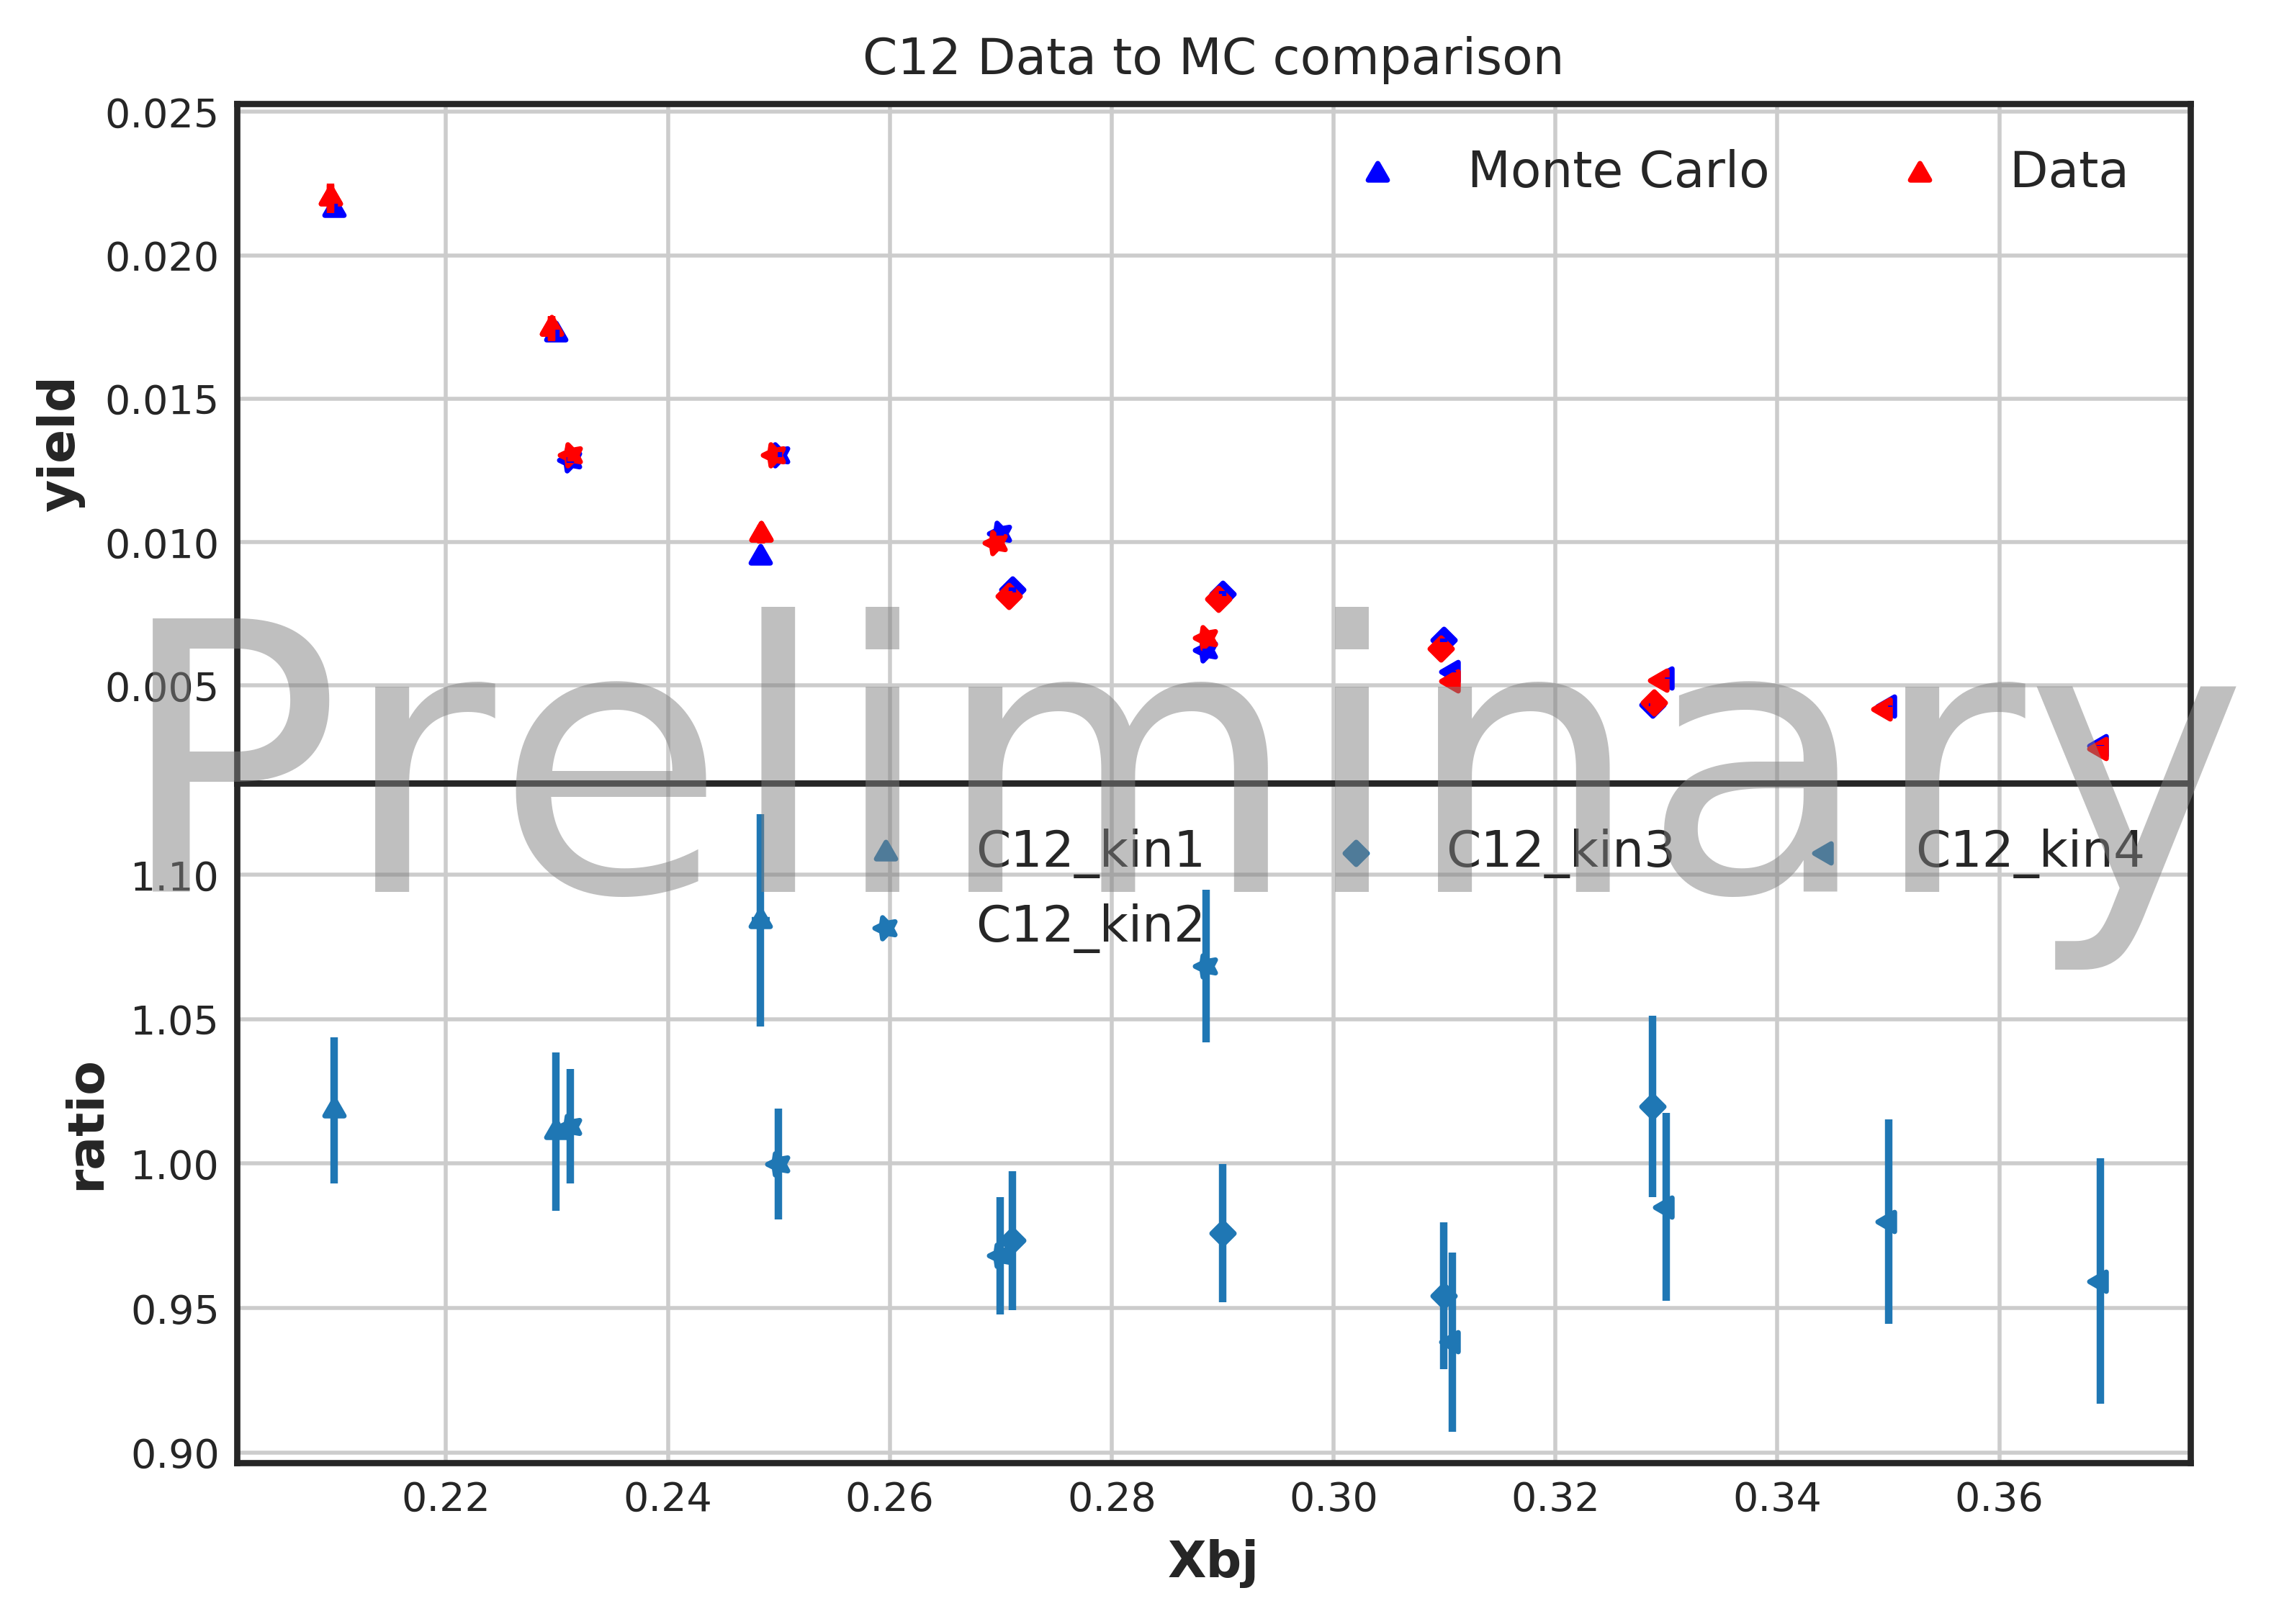

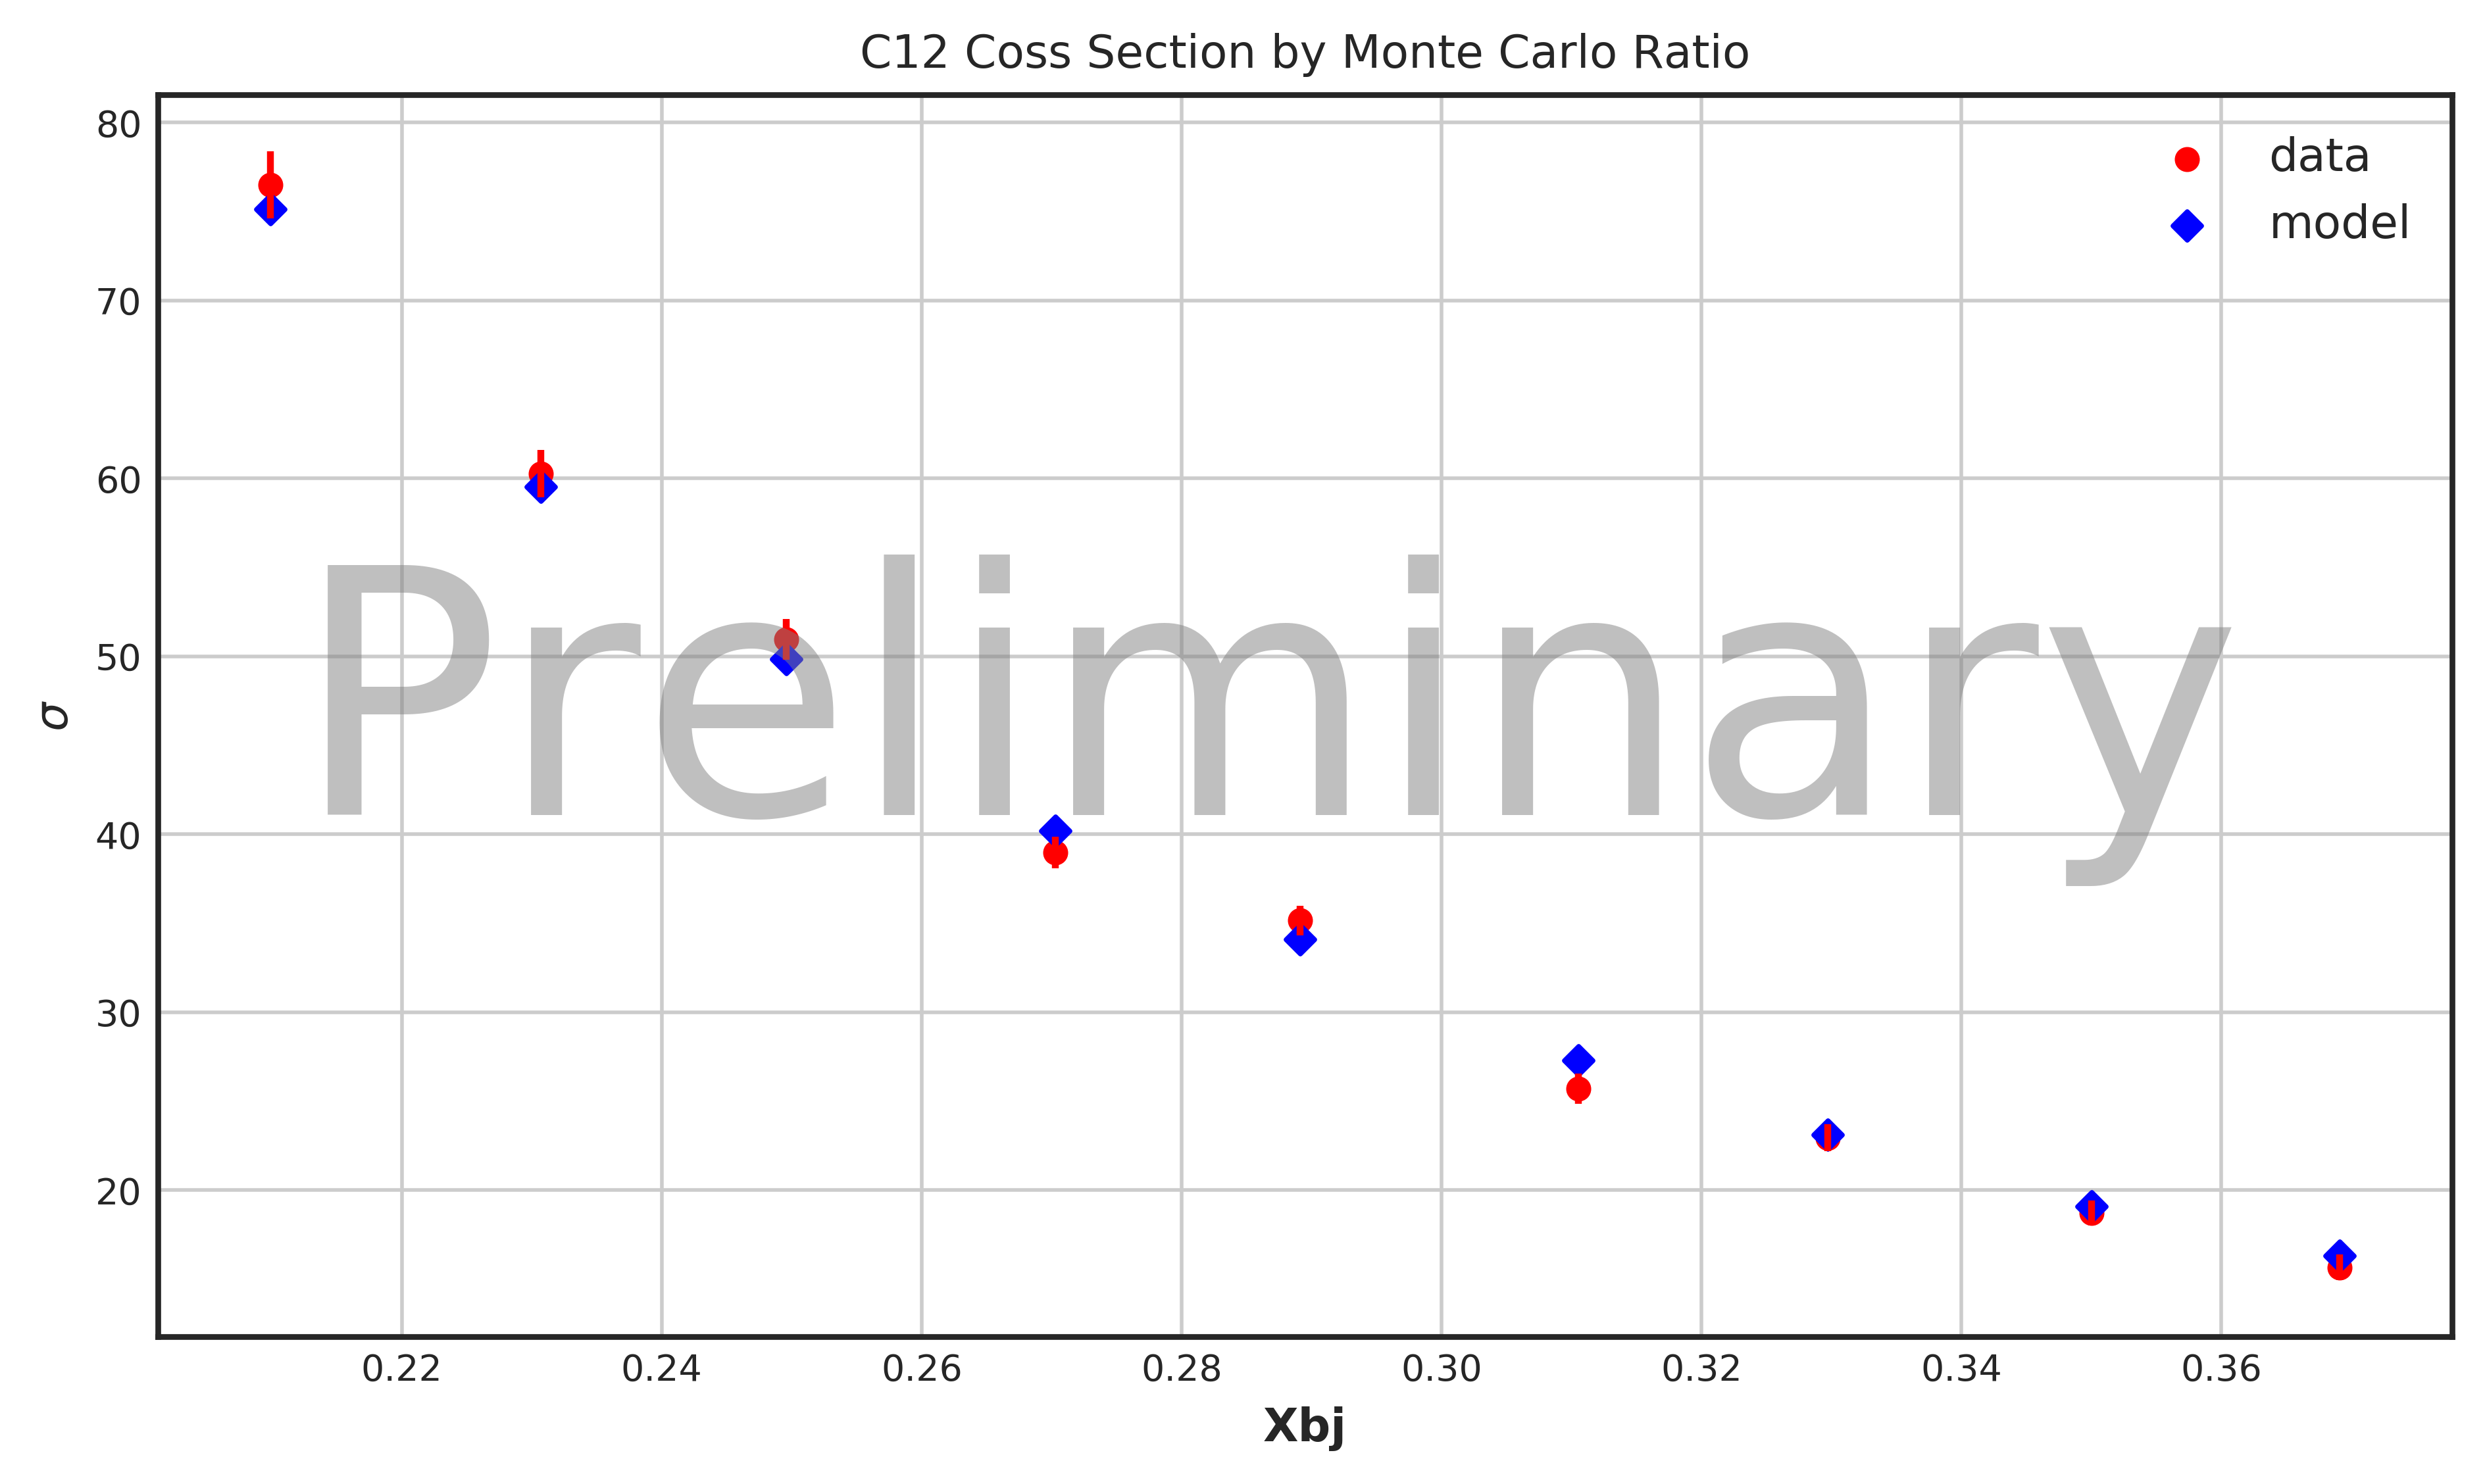

In [14]:
C12_ratios={} 
max_kin=4
bins=50
C12_ratios,kinsc12,figC12 = all_tgt("C12",bins)
C12_full =together("C12",C12_ratios,bins)
#D2_ratios = all_tgt("D2",bins)
#D2_full =together("D2",D2_ratios,bins)

In [ ]:
H3_ratios={} 
cuttype="tightcut/"
bins=50
H3_ratios = all_tgt("H3",bins)
H3_full =together("H3",H3_ratios,bins)

start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.048529 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.046334 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[7.06673451 0.         0.        ]
 [0.         5.78058089 2.21409671]
 [0.         1.44279382 4.98340948]]

0 H_kin1
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,47 m=2016 fp=0.014238 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,46 m=2016 fp=0.013843 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[5.62872011 0.         0.         0.        ]
 [0.         4.79472629 0.         0.        ]
 [0.         0.43909662 3.99296834 1.22577773]
 [0.         0.         2.25704369 3.46383959]]

1 H_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.005533 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.004983 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[3.87331875 0.         0.         0.        ]
 [0.         3.33430314 0.19792976 0.        ]
 [0.         1.5107221  2.80516375 1.65859177]
 [0.         0.         1.11511555 2.43733417]]

2 H_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.001704 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[2.73067734 0.41428771 0.         0.        ]
 [0.         2.35889733 1.11496859 0.        ]
 [0.         0.05135229 1.99861289 1.60047675]
 [0.         0.         1.4229337  1.73511256]]

3 H_kin4
[<matplotlib.collections.PathCollection object at 0x7ff5e0d03048>, <matplotlib.collections.PathCollection object at 0x7ff5e0d265f8>] ['Monte Carlo', 'Data ']


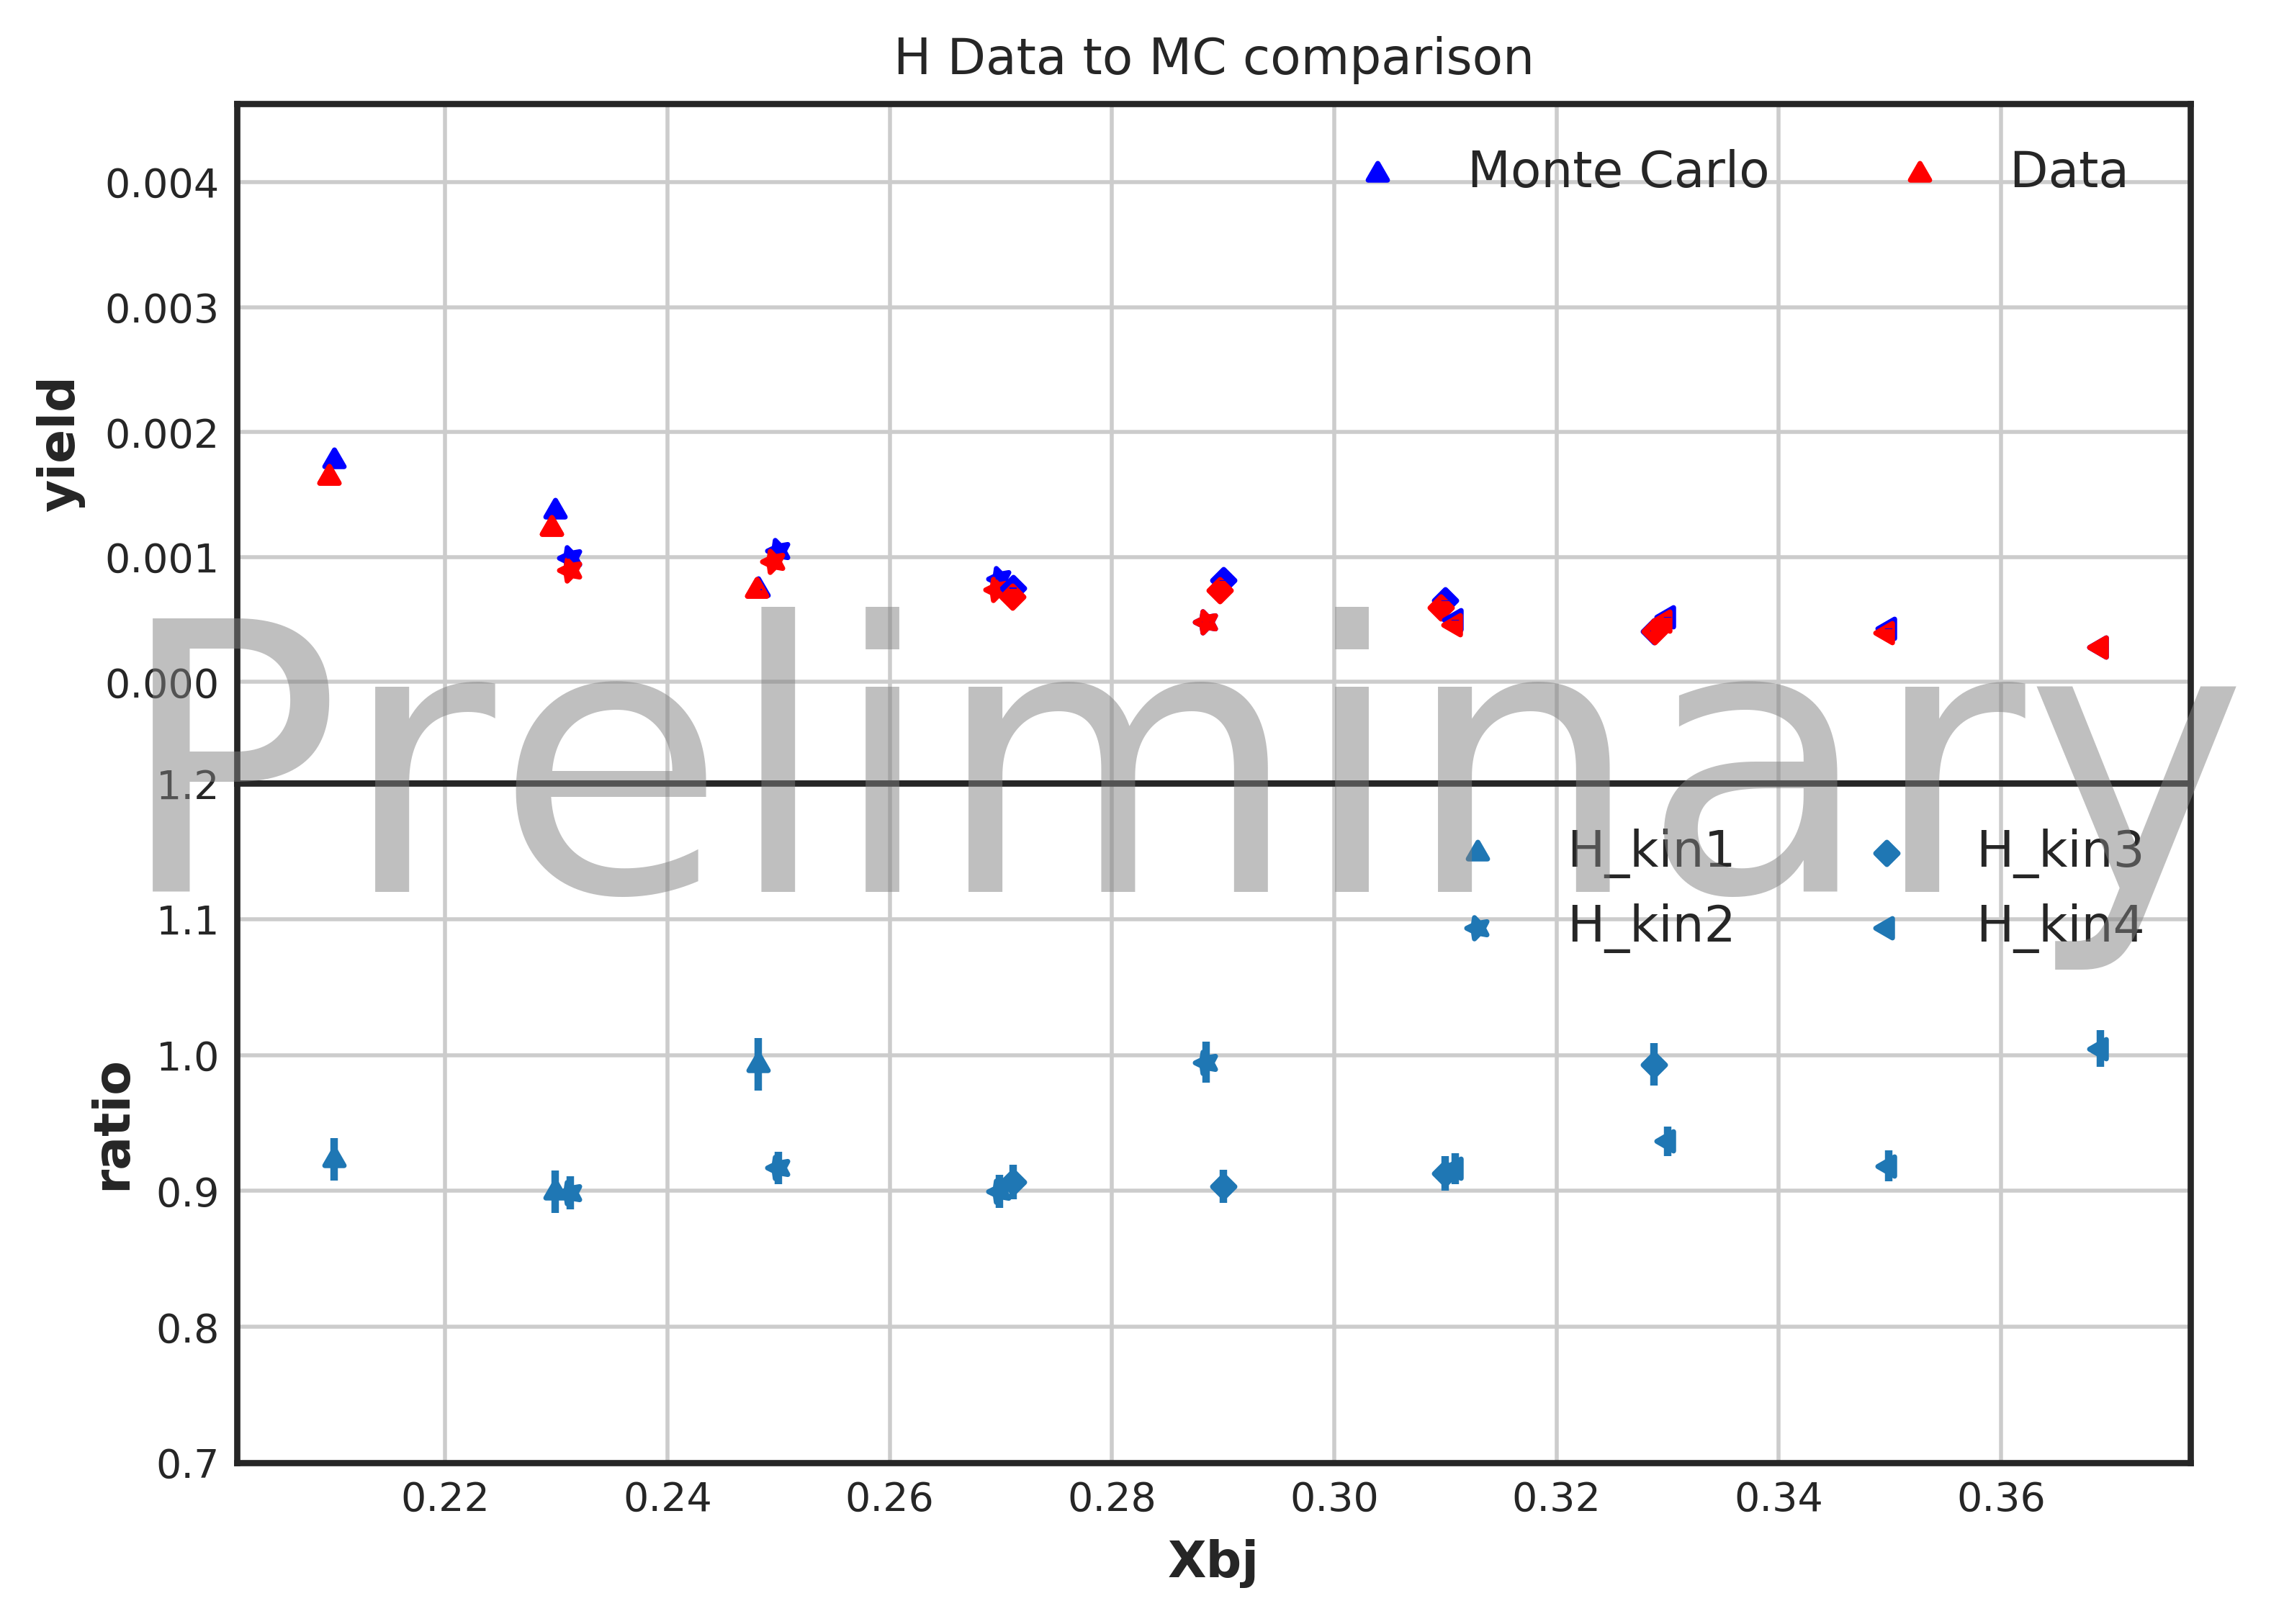

In [8]:
H_ratios={} 
cuttype="tightcut/"
bins=50
H_ratios,kins,fig = all_tgt("H",bins)



In [ ]:
H_full =together("H",H_ratios,bins)
H_ratios

start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.293125 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.282402 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[17.56995422  0.          0.        ]
 [ 0.         14.10896398  5.32073735]
 [ 0.          4.51248593 11.97472639]]

0 H3_kin1
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.085318 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,58 m=2500 fp=0.077685 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[13.72376424  0.          0.          0.        ]
 [ 1.47415749 11.51573128  3.17239393  0.        ]
 [ 0.          1.02538255  9.40692417  8.21268255]
 [ 0.          0.          3.38441715  8.04728715]]

1 H3_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.024448 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[ 9.14464306  0.          0.          0.        ]
 [ 0.93796924  7.74671027  0.          0.        ]
 [ 0.          0.56201486  6.4135256  10.02147152]
 [ 0.          0.          2.80819615  5.48801339]]

2 H3_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.009279 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[6.2477412  0.         0.         0.        ]
 [0.23174048 5.31443021 2.18451562 0.        ]
 [0.         3.13103552 4.42819975 2.29085907]
 [0.         0.         2.41533551 3.78838186]]

3 H3_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.008106 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.003308 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[4.32905556 3.51339027 0.         0.        ]
 [1.47786192 3.68868815 0.80348256 0.        ]
 [0.         2.60682228 3.07849046 2.36925747]
 [0.         0.         1.93059005 2.63531839]]

4 H3_kin5
7


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000478 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000381 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[2.41343197 2.66488404 0.         0.         0.         0.        ]
 [0.9748615  2.10028094 1.52286458 0.         0.         0.        ]
 [0.         1.39804865 1.78905731 1.9272434  0.         0.        ]
 [0.         0.         1.36251452 1.49020688 1.5870728  0.        ]
 [0.         0.         0.         1.17543499 1.26559279 1.33160222]
 [0.         0.         0.         0.         1.03015392 1.09358127]]

5 H3_kin7
9


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000079 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000063 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[1.17154226 1.23478418 0.         0.         0.         0.        ]
 [0.69876075 1.00634574 1.04812882 0.         0.         0.        ]
 [0.         0.80582259 0.84796851 0.87057149 0.         0.        ]
 [0.         0.         0.66928822 0.70020062 0.71402682 0.        ]
 [0.         0.         0.         0.57179489 0.58775036 0.59277618]
 [0.         0.         0.         0.01142648 0.48974507 0.49768773]]

6 H3_kin9
11


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000008 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000002 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.54557732 0.55128722 0.         0.         0.         0.        ]
 [0.45174971 0.45988759 0.45968554 0.         0.         0.        ]
 [0.01356107 0.37967713 0.38237042 0.37812513 0.         0.        ]
 [0.         0.         0.31205199 0.31091175 0.30456153 0.        ]
 [0.         0.         0.         0.25993782 0.25621127 0.24834067]
 [0.         0.         0.         0.09050945 0.21769065 0.21211233]]

7 H3_kin11
13


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.28607719 0.2807159  0.         0.         0.         0.
  0.        ]
 [0.24156993 0.23834628 0.23123365 0.         0.         0.
  0.        ]
 [0.         0.20143426 0.19655281 0.1887573  0.         0.
  0.        ]
 [0.         0.         0.16553533 0.15983522 0.15180622 0.02698687
  0.        ]
 [0.         0.         0.         0.1332519  0.12724685 0.11985901
  0.09598269]
 [0.         0.         0.         0.04470001 0.10843051 0.10258284
  0.09551785]
 [0.         0.         0.         0.         0.04060238 0.08848
  0.0827008 ]]

8 H3_kin13
15


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.11766836 0.11094016 0.02561774 0.         0.         0.
  0.        ]
 [0.10079315 0.09543692 0.08891909 0.05692541 0.         0.
  0.        ]
 [0.01984547 0.08181507 0.07655598 0.07066814 0.06396666 0.
  0.        ]
 [0.         0.0203366  0.06553388 0.06071402 0.0554378  0.04500799
  0.01228753]
 [0.         0.         0.0204435  0.05152865 0.04722138 0.04277583
  0.03485413]
 [0.         0.         0.         0.0187793  0.04071341 0.03697768
  0.0331627 ]
 [0.         0.         0.         0.00856193 0.03458763 0.03223815
  0.02897565]]

9 H3_kin15
[<matplotlib.collections.PathCollection object at 0x7fb76821df28>, <matplotlib.collections.PathCollection object at 0x7fb76fc54710>, <matplotlib.collections.PathCollection object at 0x7fb76e8d6668>, <matplotlib.collections.PathCollection object at 0x7fb768075160>] ['Monte Carlo', 'Data ', 'Monte Carlo', 'Data ']


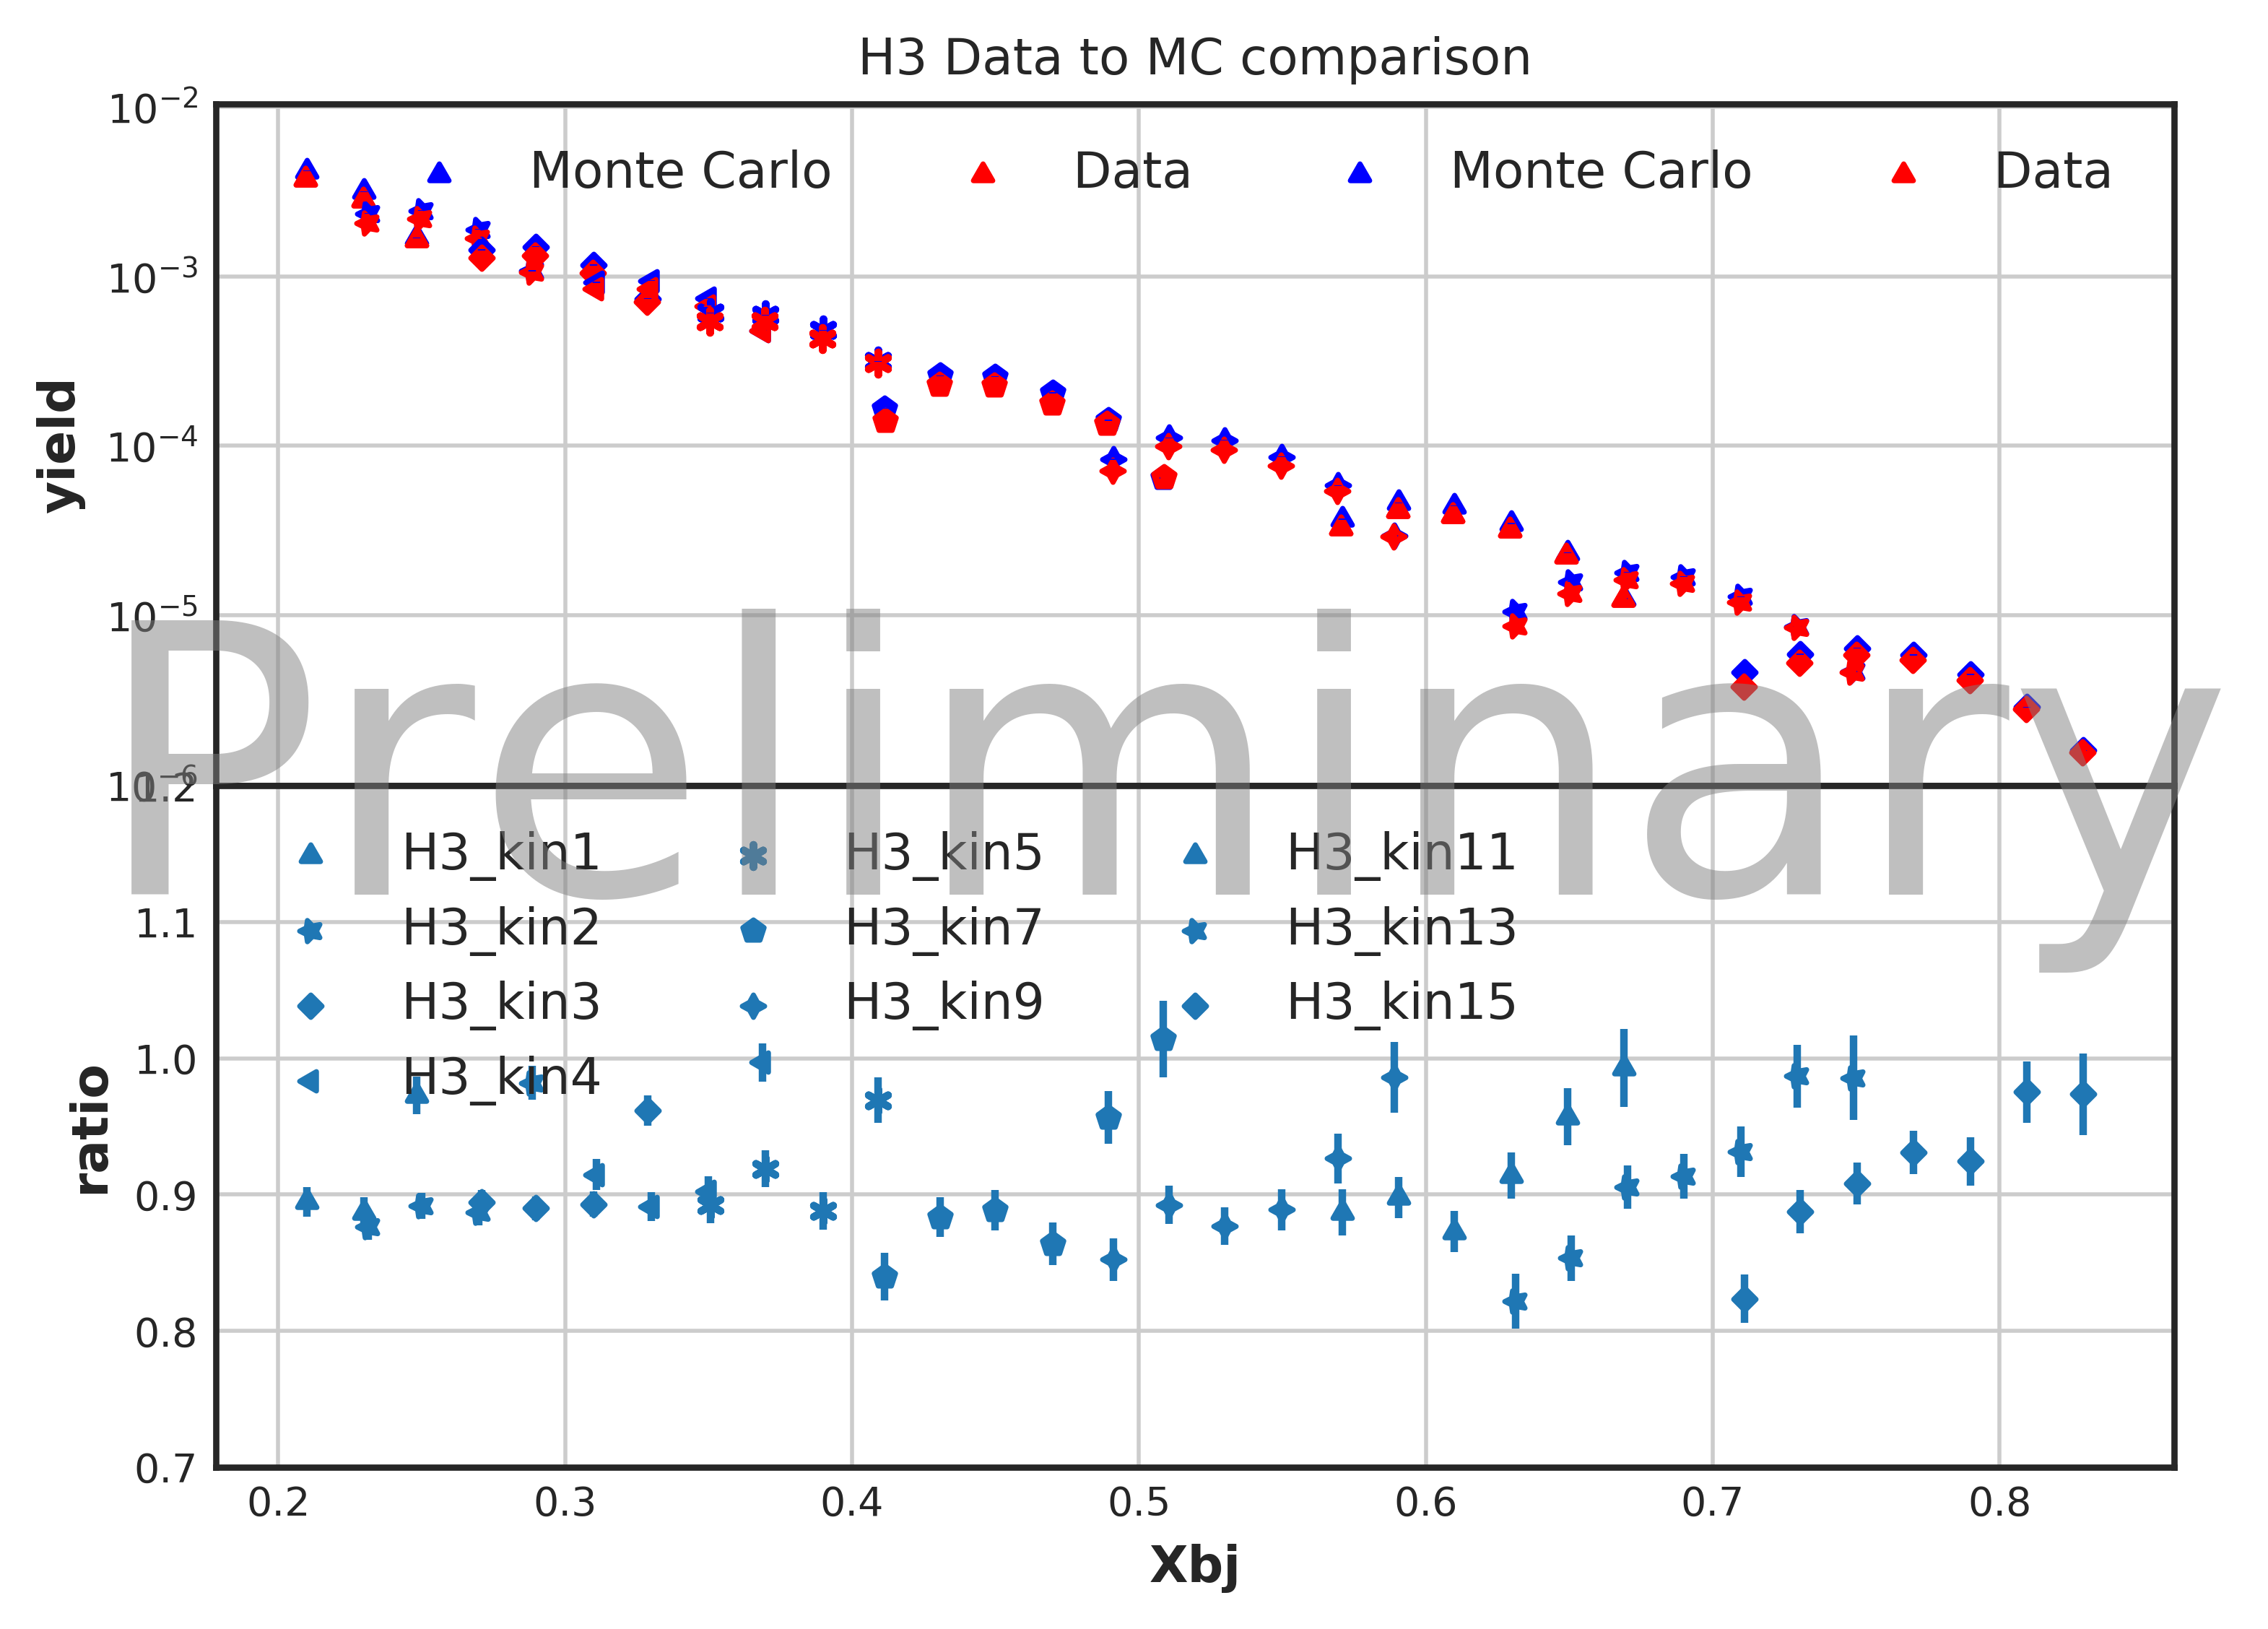

In [38]:
H3_ratios={} 
cuttype="tightcut/"
bins=50
H3_ratios,kins3,figH3 = all_tgt("H3",bins)


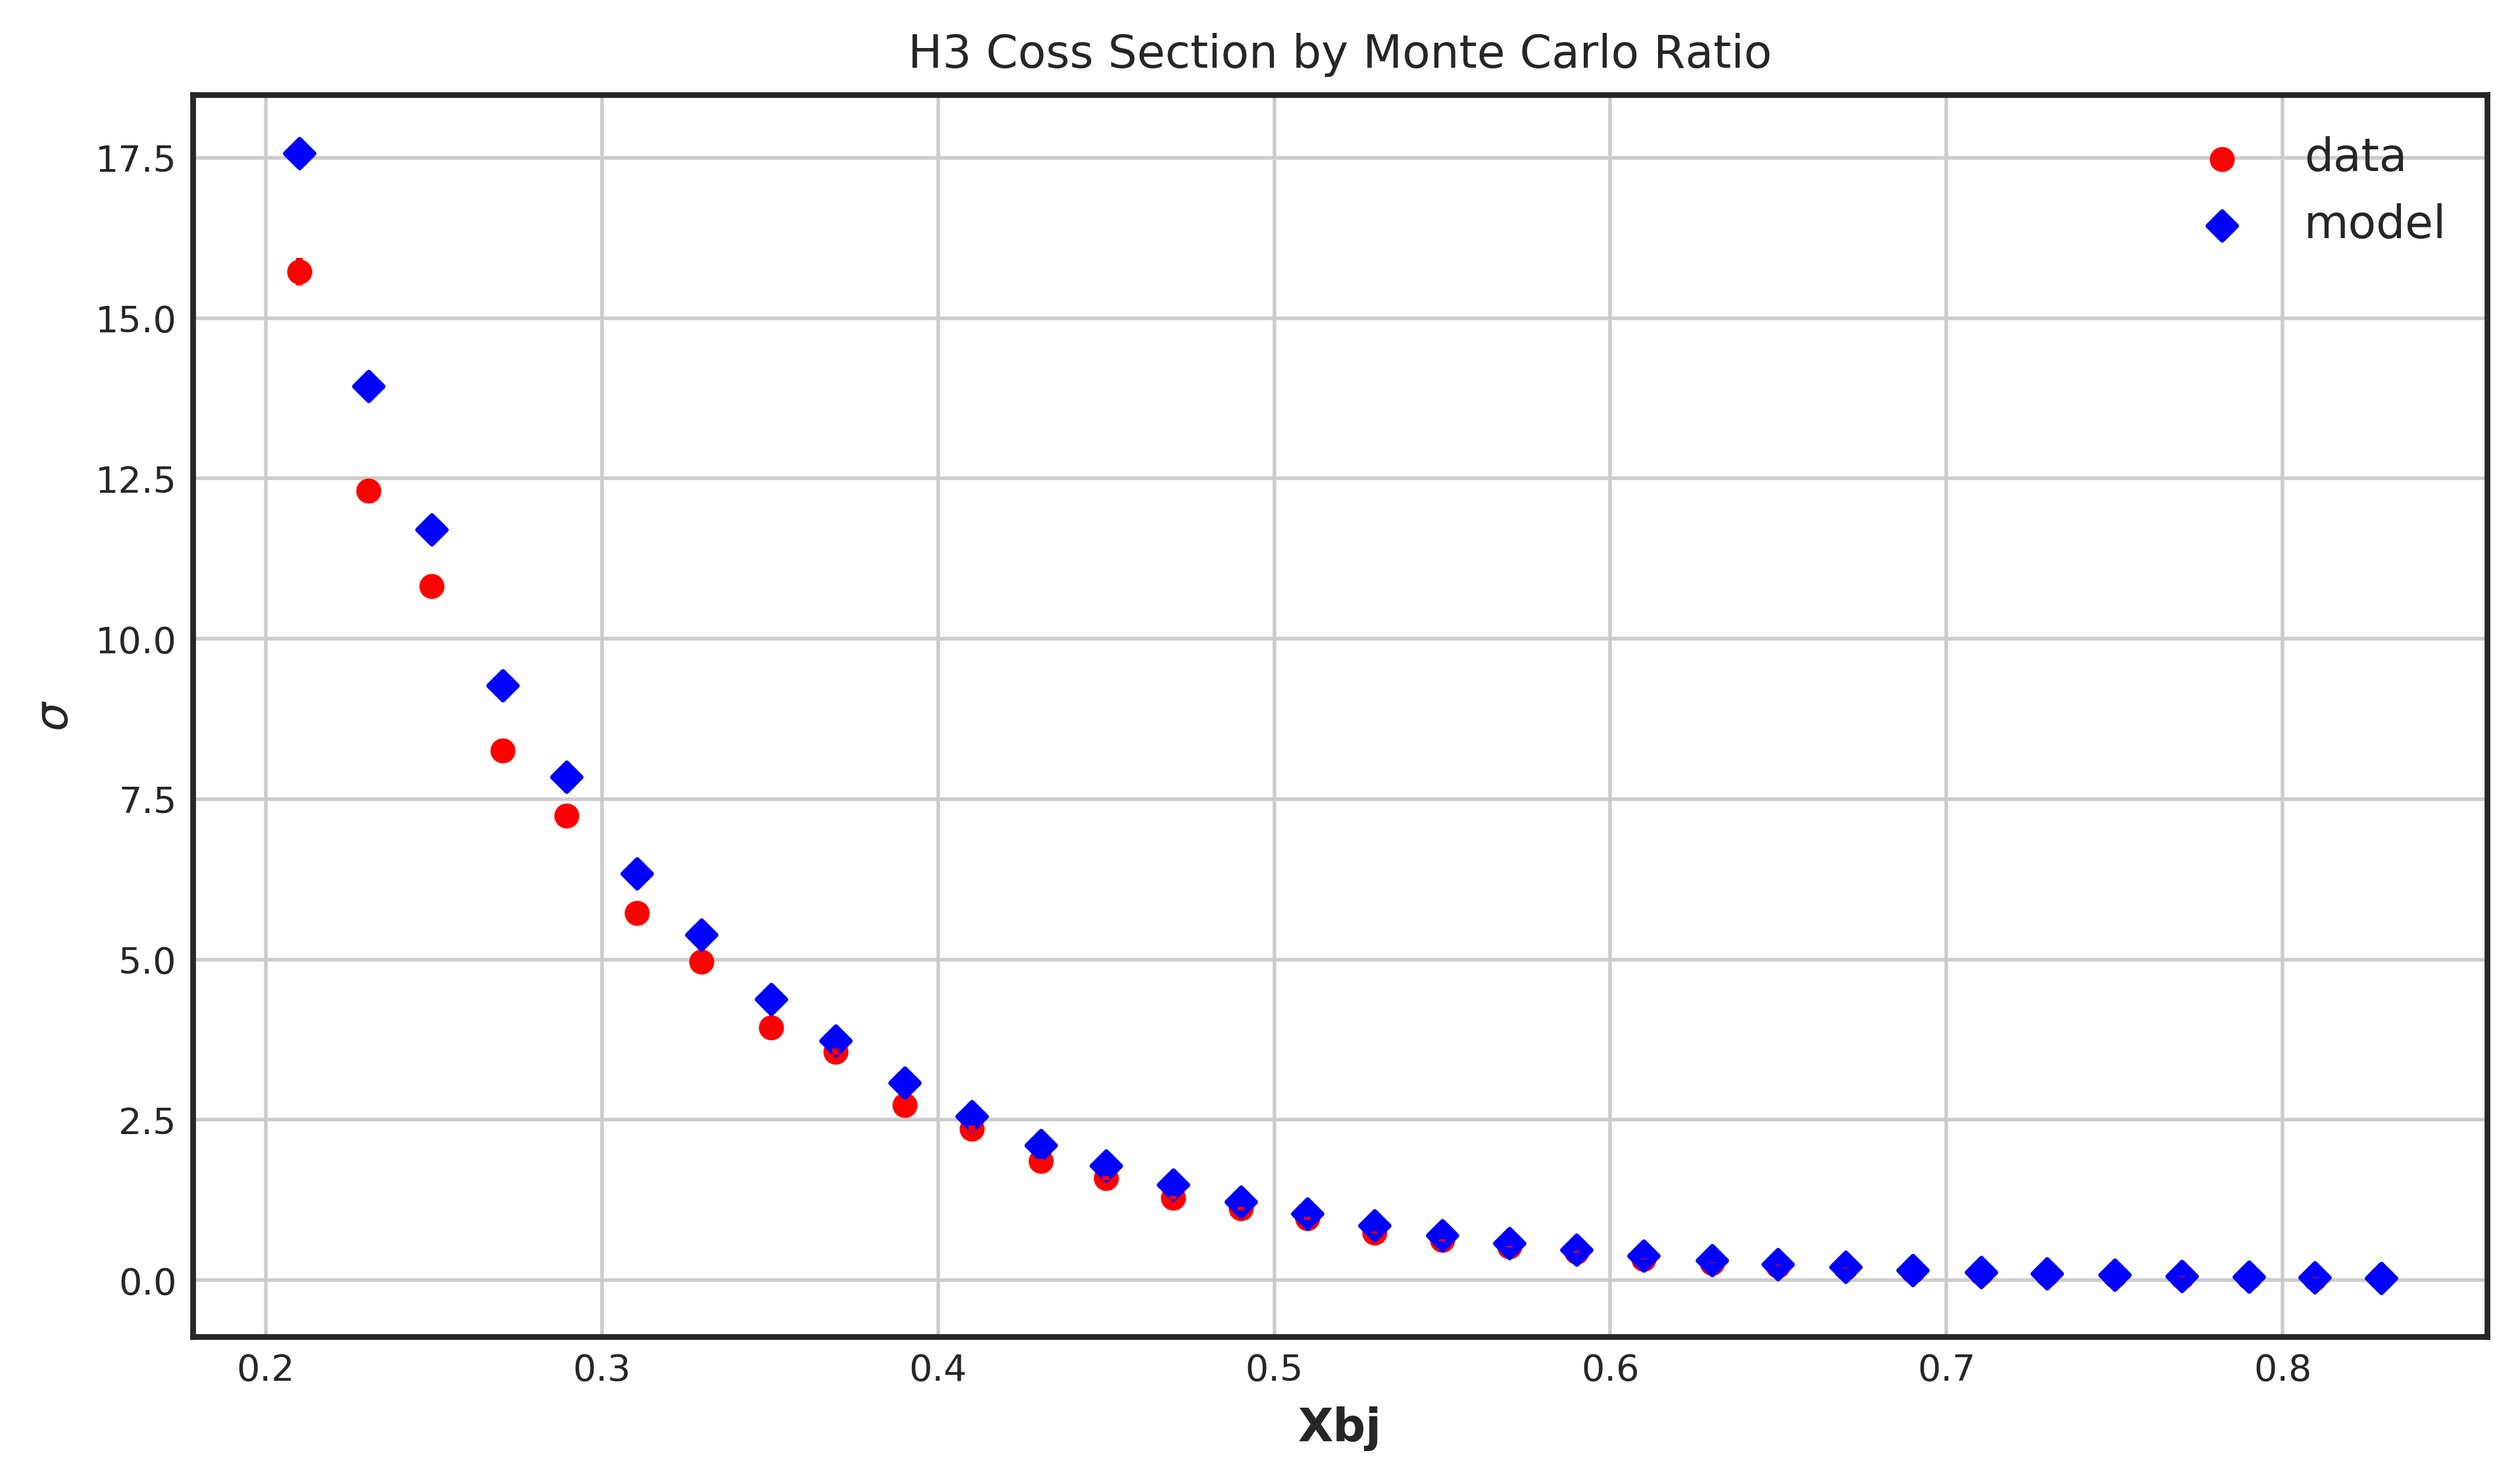

In [9]:
H3_full =together("H3",H3_ratios,bins)


start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.139554 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.143036 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[12.33557541  0.          0.        ]
 [ 0.          9.95168935  3.46398954]
 [ 0.          3.17553605  8.49812743]]

0 D2_kin1
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.041695 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.015774 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[9.69485487 0.26264464 0.         0.        ]
 [0.         8.18064987 0.88097648 0.        ]
 [0.         0.         6.72433622 0.80932871]
 [0.         0.         2.65357774 5.77088382]]

1 D2_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.012942 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.004710 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[6.54218528 0.0874111  0.         0.        ]
 [2.44660469 5.56365176 1.61063506 0.        ]
 [0.         0.         4.62248318 2.77012095]
 [0.         0.         0.65967106 3.97588309]]

2 D2_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=53,52 m=2500 fp=0.004572 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.001818 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[4.50827731 0.         0.         0.        ]
 [0.         3.85676105 0.51350148 0.        ]
 [0.         0.20477736 3.22657351 2.60229029]
 [0.         0.         1.5226184  2.7765992 ]]

3 D2_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.001455 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000277 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[3.15370883 0.59783413 0.         0.        ]
 [0.82651011 2.70204693 1.25500837 0.        ]
 [0.         0.78791232 2.26715514 2.21759567]
 [0.         0.         1.43199649 1.94746805]]

4 D2_kin5
7


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000203 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000046 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[1.78313129 1.97599727 0.         0.         0.         0.        ]
 [1.27372766 1.56306113 1.12098969 0.         0.         0.        ]
 [0.         1.08347619 1.33630469 1.4555106  0.         0.        ]
 [0.         0.         1.02116633 1.12027788 1.05865961 0.        ]
 [0.         0.         0.         0.88508895 0.95545434 0.92978526]
 [0.         0.         0.         0.         0.77825321 0.83079292]]

5 D2_kin7
9


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000034 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000006 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.88527444 0.93787786 0.         0.         0.         0.        ]
 [0.60197762 0.76407851 0.79975459 0.         0.         0.        ]
 [0.         0.6108     0.64636048 0.66968648 0.         0.        ]
 [0.         0.         0.51339557 0.5373216  0.5504125  0.        ]
 [0.         0.         0.         0.43858949 0.4527969  0.45926783]
 [0.         0.         0.         0.         0.37757683 0.3854548 ]]

6 D2_kin9
11


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000004 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.42115207 0.42753809 0.         0.         0.         0.        ]
 [0.34887976 0.3568339  0.35825967 0.         0.         0.        ]
 [0.         0.29385638 0.29726708 0.29518097 0.         0.        ]
 [0.         0.         0.24274198 0.24283946 0.23871345 0.        ]
 [0.         0.         0.         0.20312663 0.2008982  0.1953175 ]
 [0.         0.         0.         0.06228305 0.17062861 0.16671429]]

7 D2_kin11
13


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[0.22388559 0.22045777 0.         0.         0.         0.
  0.        ]
 [0.17896823 0.18716507 0.1821239  0.0459423  0.         0.
  0.        ]
 [0.         0.15808748 0.15472774 0.14886918 0.         0.
  0.        ]
 [0.         0.         0.13010903 0.12585842 0.11972364 0.03642031
  0.        ]
 [0.         0.         0.         0.10516303 0.10057374 0.09470517
  0.07160804]
 [0.         0.         0.         0.03271097 0.08566123 0.08101052
  0.07534462]
 [0.         0.         0.         0.         0.03286922 0.06990184
  0.06525345]]

8 D2_kin13
15


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.09313033 0.08773754 0.01750734 0.         0.         0.
  0.        ]
 [0.07966931 0.07541309 0.07018965 0.05067197 0.00076779 0.
  0.        ]
 [0.02824319 0.06471584 0.06046265 0.05558848 0.04701567 0.
  0.        ]
 [0.         0.00933139 0.05174666 0.04774737 0.04336761 0.03710828
  0.00638144]
 [0.         0.         0.00875388 0.04053308 0.03694564 0.03316216
  0.02702257]
 [0.         0.         0.00039303 0.03911505 0.03189078 0.02870778
  0.02543266]
 [0.         0.         0.         0.         0.02608871 0.02500019
  0.02219539]]

9 D2_kin15
[<matplotlib.collections.PathCollection object at 0x7fb76e18b748>, <matplotlib.collections.PathCollection object at 0x7fb7680b25c0>, <matplotlib.collections.PathCollection object at 0x7fb768a04710>, <matplotlib.collections.PathCollection object at 0x7fb768a04b00>] ['Monte Carlo', 'Data ', 'Monte Carlo', 'Data ']


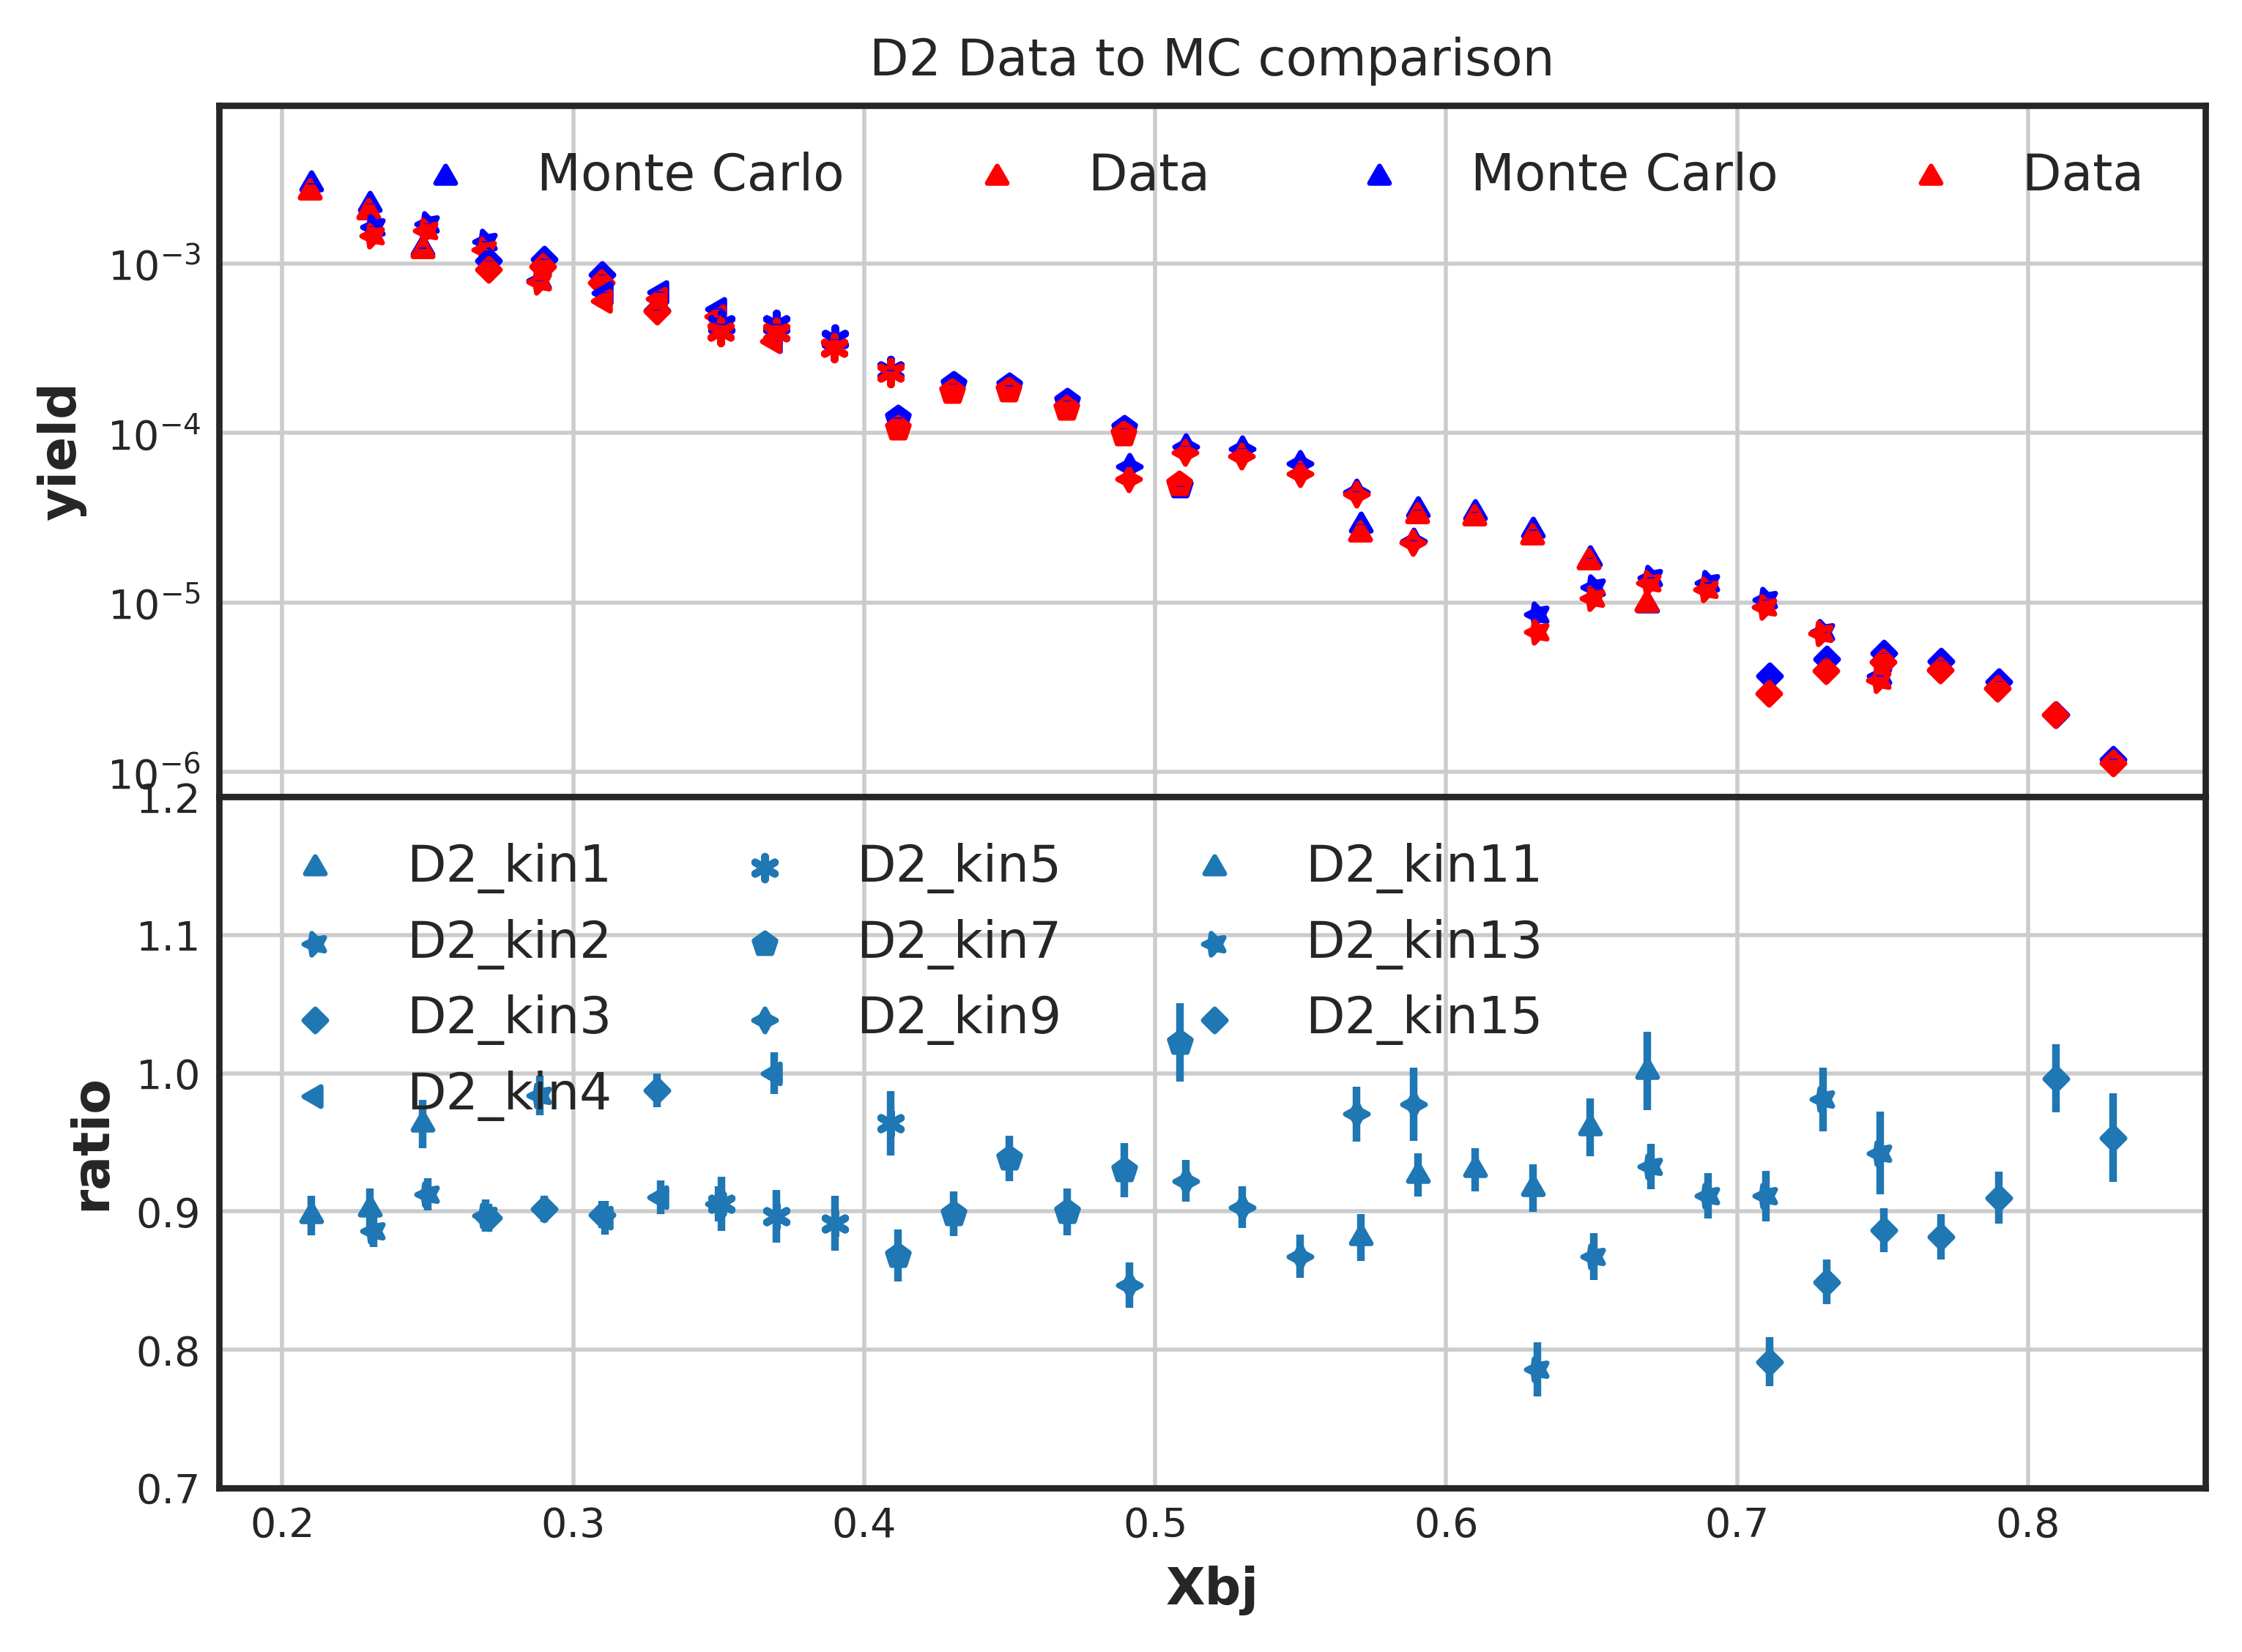

In [16]:
D2_ratios={} 
cuttype="tightcut/"
bins=50
D2_ratios,kinsd2,figd2 = all_tgt("D2",bins)


In [ ]:
D2_full =together("D2",D2_ratios,bins)

start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.366705 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.426432 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[19.60537384  0.          0.        ]
 [ 0.         15.85074819  6.12163933]
 [ 0.          4.37797469 13.59527919]]

0 He3_kin1
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.105030 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.039761 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[15.50166358  0.          0.          0.        ]
 [ 0.99841881 13.09771718  2.62502866  0.        ]
 [ 0.         21.18210938 10.78289018  7.52699327]
 [ 0.          0.          3.96920038  9.29262627]]

1 He3_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.033630 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[10.49283178  0.          0.          0.        ]
 [ 0.          8.94311226  0.25780387  0.        ]
 [ 0.          0.18924699  7.44686646  4.59272949]
 [ 0.          0.          2.96486974  6.42201942]]

2 He3_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.012296 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.010368 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[7.27373339 0.         0.         0.        ]
 [0.         6.22147228 1.13561005 0.        ]
 [0.         0.39683691 5.20808694 2.79061389]
 [0.         0.         2.73431349 4.49139579]]

3 He3_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.004644 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.004051 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[5.09781969 0.60864166 0.         0.        ]
 [3.03636166 4.37464383 2.4685839  0.        ]
 [0.         2.88539184 3.66788272 3.63917411]
 [0.         0.         2.76629011 3.1588665 ]]

4 He3_kin5
7


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=46,59 m=2500 fp=0.000514 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.000121 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[2.89498717 3.21184331 0.         0.         0.         0.        ]
 [0.96448532 2.53752363 1.79949416 0.         0.         0.        ]
 [0.         1.84140729 2.16937963 2.36883016 0.         0.        ]
 [0.         0.         1.65109675 1.81427822 1.95042271 0.        ]
 [0.         0.         0.         1.43852339 1.55259691 1.51948981]
 [0.         0.         0.         0.         1.26157203 1.34844117]]

5 He3_kin7
9


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000091 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[1.43879824 1.52568457 0.         0.         0.         0.        ]
 [0.93214047 1.24346137 1.30255824 0.         0.         0.        ]
 [0.         0.99513059 1.05333    1.0925144  0.         0.        ]
 [0.         0.         0.832844   0.8730783  0.89558441 0.        ]
 [0.         0.         0.         0.71381172 0.73776714 0.74921431]
 [0.         0.         0.         0.         0.61544972 0.62916187]]

6 He3_kin9
11


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,58 m=2500 fp=0.000015 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,58 m=2500 fp=0.000013 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[0.68630334 0.6975955  0.         0.         0.         0.        ]
 [0.56905527 0.58278324 0.58598841 0.         0.         0.        ]
 [0.         0.47969144 0.48595667 0.48336512 0.         0.        ]
 [0.         0.         0.39600839 0.39684108 0.39089234 0.12744366]
 [0.         0.         0.04886945 0.33221365 0.32919131 0.32071763]
 [0.         0.         0.         0.09335642 0.27982995 0.27402142]]

7 He3_kin11
13


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,56 m=2500 fp=0.000002 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[0.36650552 0.36159619 0.         0.         0.         0.
  0.        ]
 [0.27630521 0.30714042 0.29949126 0.0808479  0.         0.
  0.        ]
 [0.         0.25939499 0.25436963 0.24542715 0.         0.
  0.        ]
 [0.         0.         0.21415407 0.20771053 0.1980798  0.06527162
  0.        ]
 [0.         0.         0.         0.17307582 0.16594238 0.1567363
  0.01579204]
 [0.         0.         0.         0.04642528 0.141364   0.13409568
  0.12526483]
 [0.         0.         0.         0.         0.06075672 0.11571004
  0.1084979 ]]

8 He3_kin13
15

[[0.15360834 0.14530281 0.06132144 0.         0.         0.
  0.        ]
 [0.13171559 0.12518016 0.11693251 0.1002067  0.         0.
  0.        ]
 [0.00426562 0.1071935  0.10053603 0.09302266 0.06868062 0.
  0.        ]
 [0.         0.         0.08614056 0.07999158 0.0731407  0.06041344
  0.01052991]
 [0.         0.         0.03315235 0.06778052 0.06219764 0.05628284
  0.04704939]
 [0.         0.         0.         0.05804448 

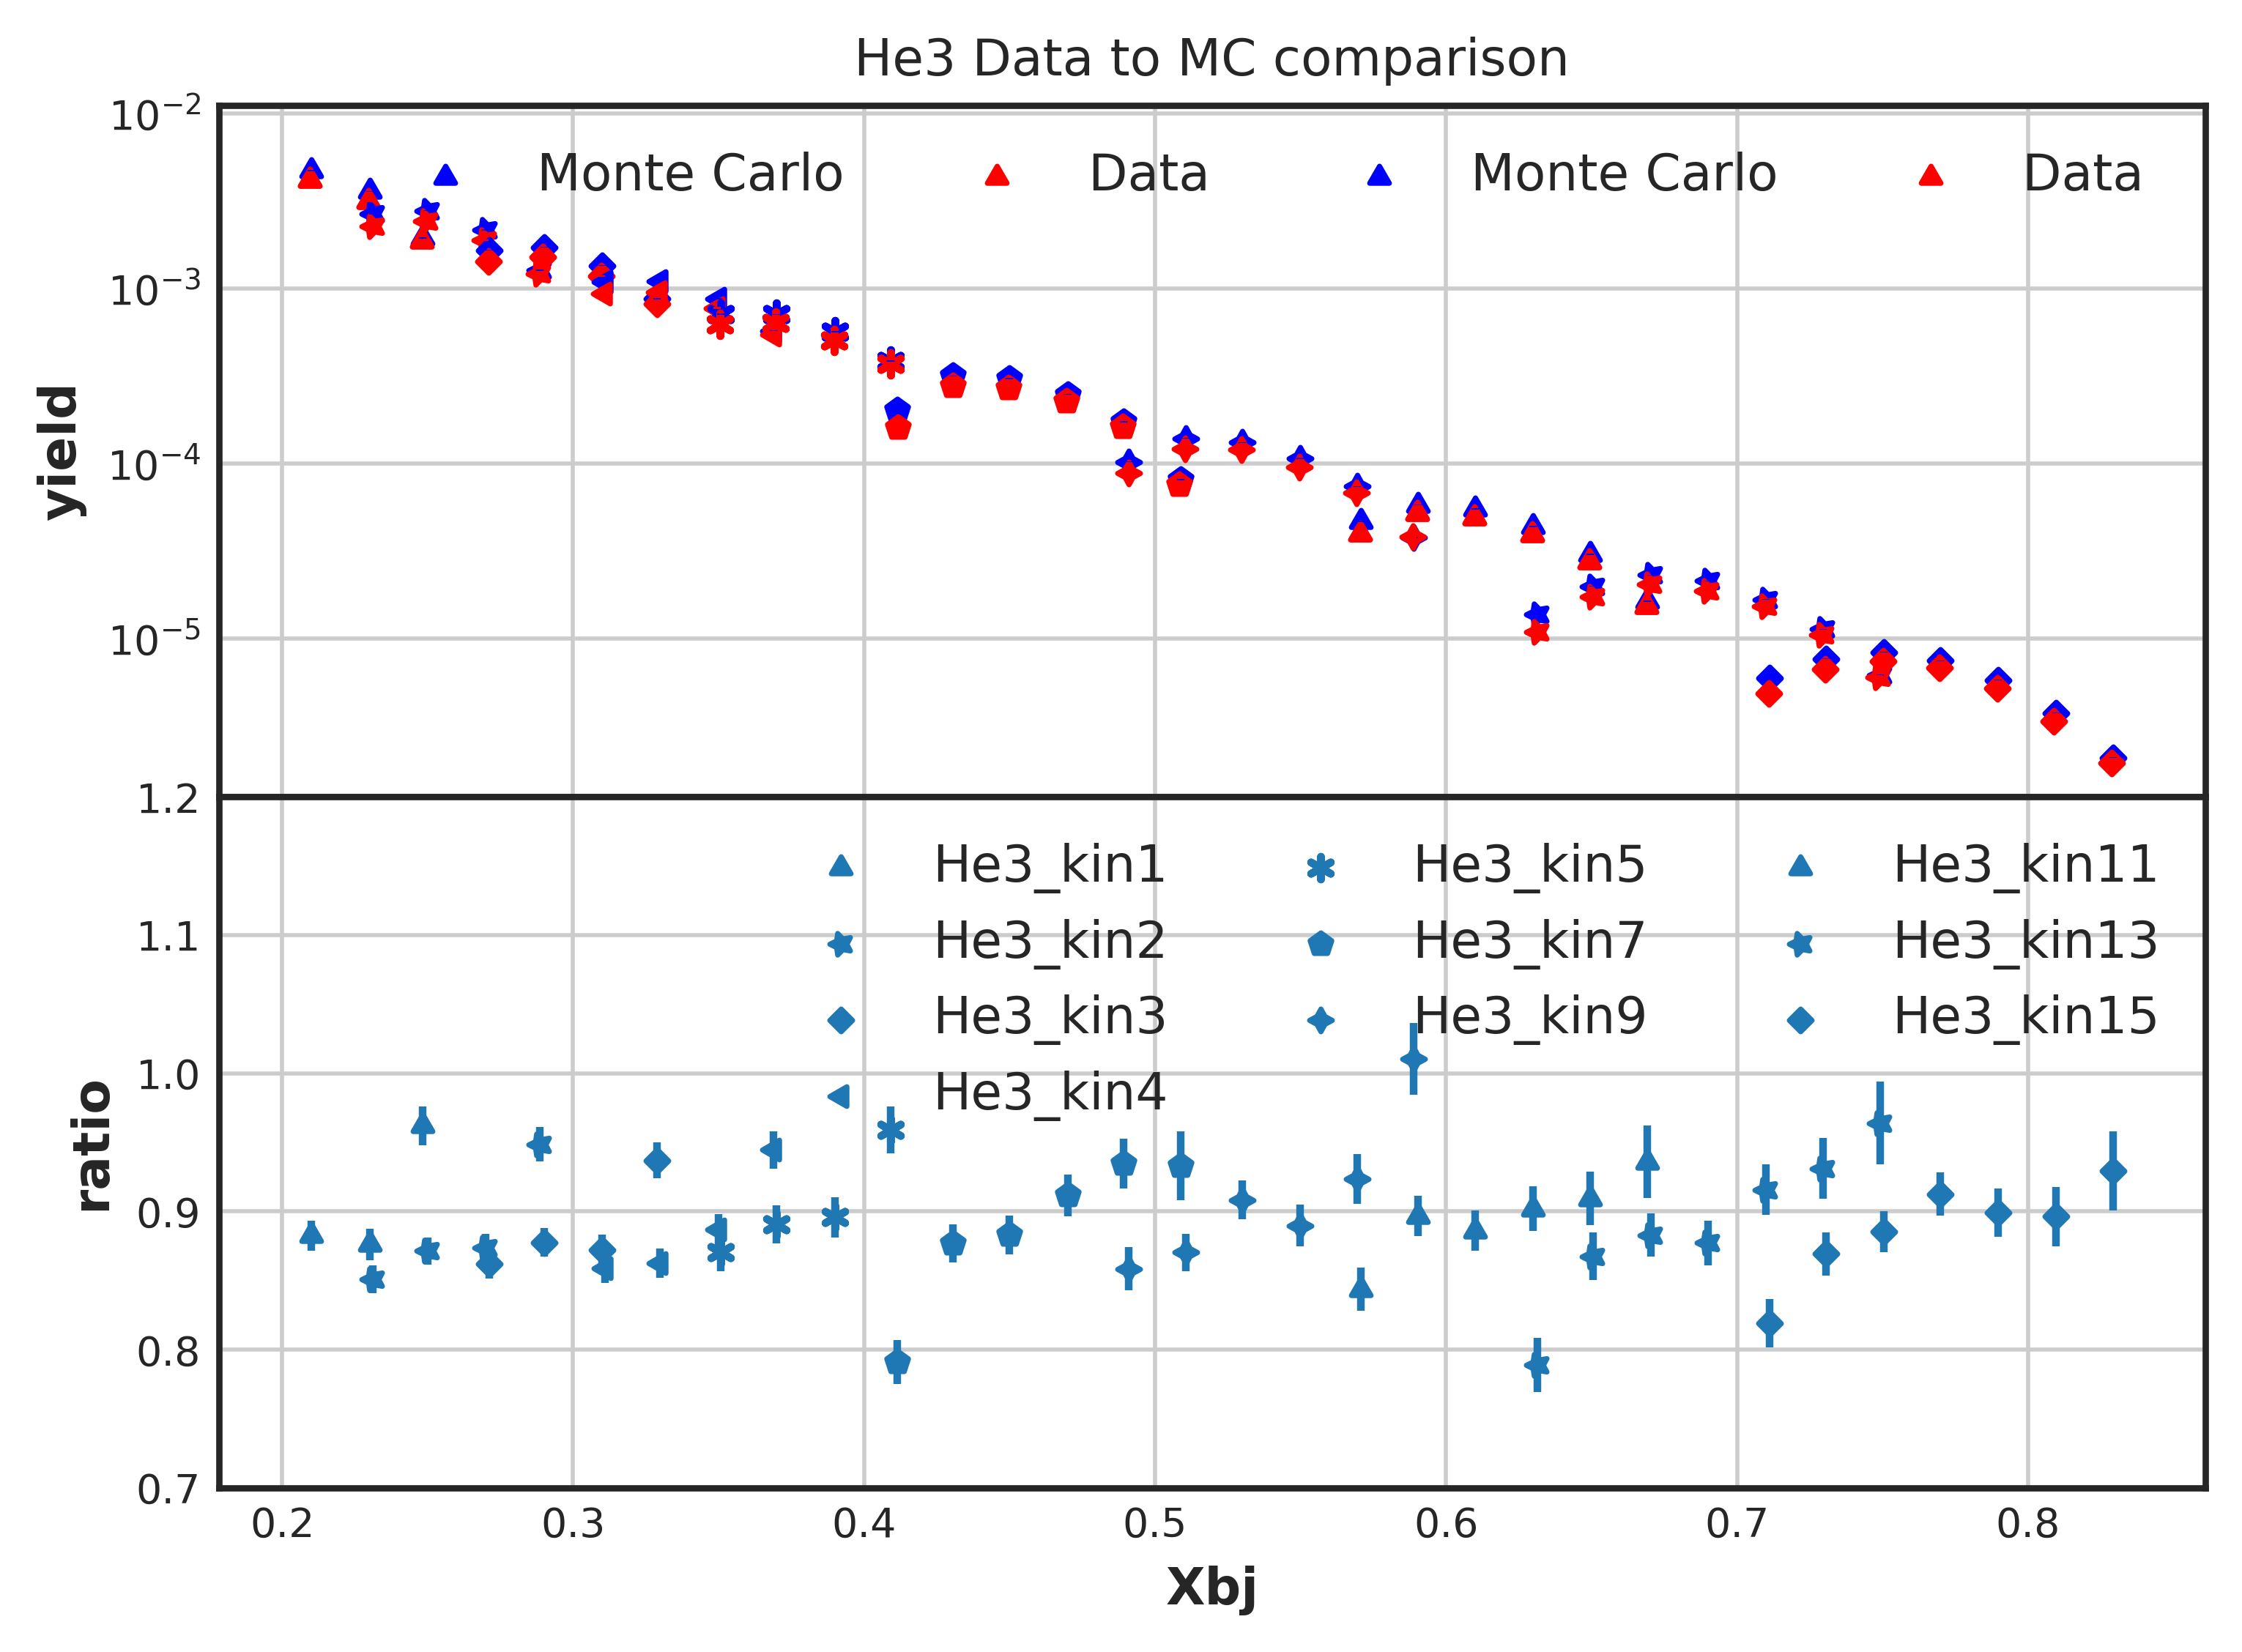

In [15]:
He3_ratios={} 
cuttype="tightcut/"
bins=50
He3_ratios,kinshe3,fighe3 = all_tgt("He3",bins)

In [ ]:
He3_full =together("He3",He3_ratios,bins)

In [99]:
aa = pd.concat(H_ratios)

cname =aa.columns
numofc=len(cname)
aa[cname]
ab={}

#ac = wavg(aa, cname,"Sig_Born_err")
for i,col in enumerate(cname):
    ab[i]=aa.groupby(level=1).apply(wavg,col ,"Sig_Born_err")

newdf = pd.DataFrame.from_dict(ab)
newdf.columns = cname
    


    

(0.85, 1.05)

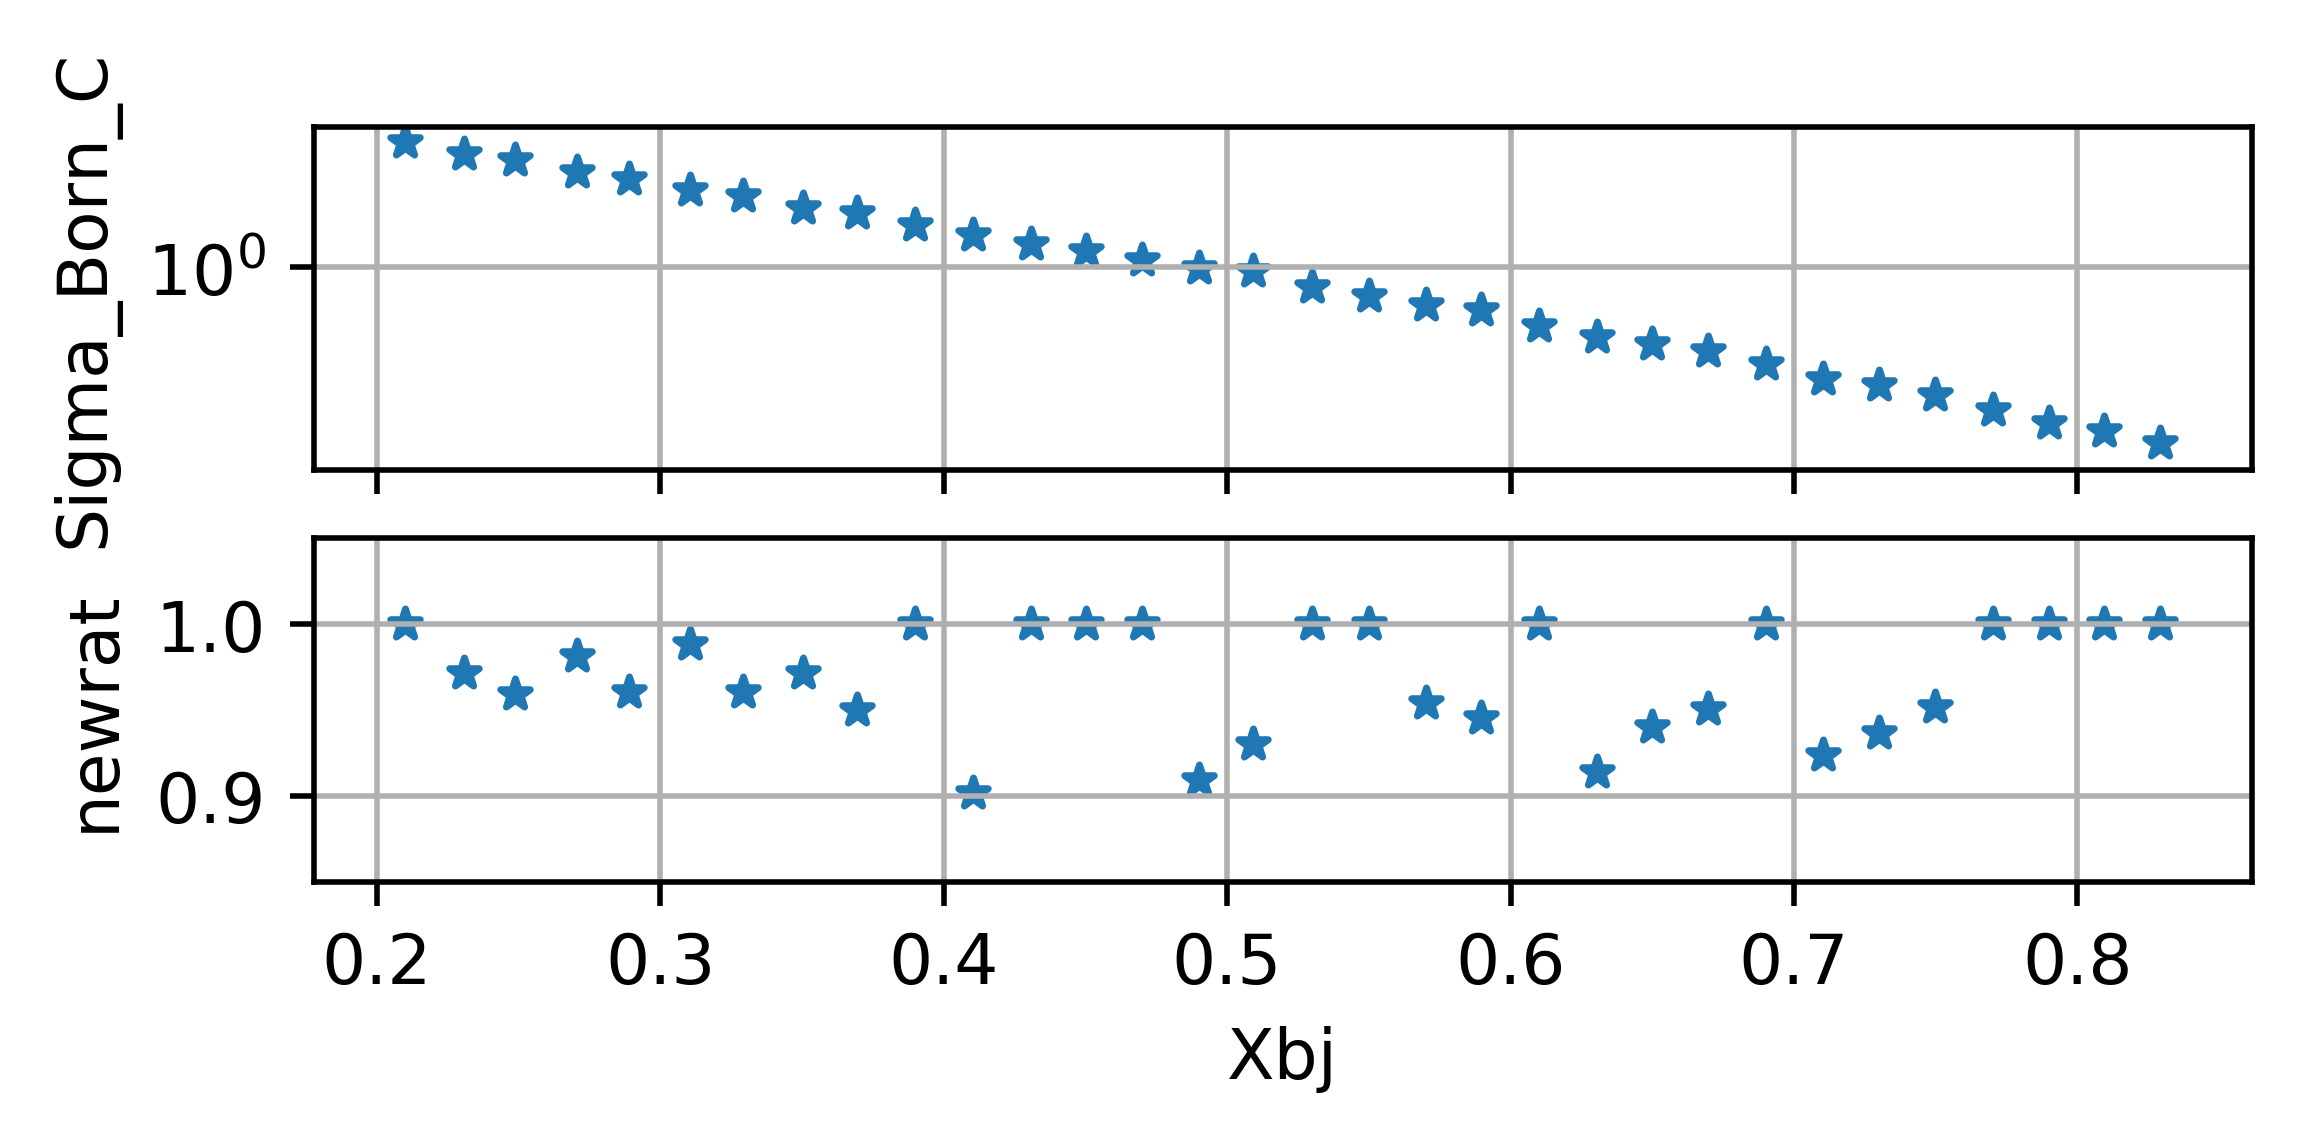

In [229]:
fig= plt.figure(dpi=500,figsize=(5,2))
    #plt.title('Cross section ratio Isoscalar corrected')
x=fig.add_subplot(2,1,1)


newrat = newdf
newrat['newrat'] = newrat['Sigma_Born_C']/H3_full['Sigma_Born_C']

newdf.plot(ax=x,x='Xbj',y='Sigma_Born_C',kind='Scatter',marker='*')
#H3_full.plot(ax=x,x='Xbj',y='Sigma_Born_C',kind='Scatter',marker='1')

xx=fig.add_subplot(2,1,2, sharex=x)
newdf.plot(ax=xx,x='Xbj',y='newrat',kind='Scatter',marker='*')
x.set_yscale("log")

x.grid(True)
xx.grid(True)
xx.set_ylim(0.85,1.05)


In [ ]:
H3_full =together("H3",H3_ratios,bins)
H3_ratios

In [97]:
new = H3_full
new['ratio_of_ratio'] = H3_full['ratio']/H3_full_2['ratio']


In [ ]:
newfig = plt.figure(dpi=500,figsize=(11,5))
axis = newfig.add_subplot(2,1,1)
H3_full.plot(ax=axis,y="Sigma_Born_C",x='Xbj',yerr='Sig_Born_err',kind="scatter",label="H3 tight cut" )
H3_full_2.plot(ax=axis,y="Sigma_Born_C",x='Xbj',yerr='Sig_Born_err',kind="scatter",color='r',marker='*',label="H3 lose cut" )

newdf=H3_full[['Xbj','Sigma_Born_C','Sig_Born_err']].copy()
newdf['Sigma_l']=H3_full_2["Sigma_Born_C"].copy()
newdf['Sigma_ratio']=H3_full['Sigma_Born_C']/H3_full_2["Sigma_Born_C"]
newdf['ratio_err'] = newdf['Sigma_ratio'] * np.sqrt( (newdf['Sig_Born_err']/newdf['Sigma_Born_C'])**2 + (H3_full_2['Sig_Born_err']/H3_full_2['Sigma_Born_C'])**2 )
axis2 = newfig.add_subplot(2,1,2,sharex=axis)
newdf.plot(ax=axis2,y="Sigma_ratio",x='Xbj',yerr='ratio_err',kind="scatter",color='r',marker='*',label="H3 Sigma ratio" )
      

axis.set_yscale("log")
newfig.subplots_adjust(hspace=0)
axis.grid(True)
axis2.grid(True)

In [123]:
newfig.savefig('./images/H3_cutscomp.eps',bbox_inches='tight')

In [ ]:
cuttype=""
H3_ratios_2 = all_tgt("H3",bins)
H3_full_2 =together("H3",H3_ratios_2,bins)

In [ ]:
D2_ratios={}
He3_ratios={}
H3_ratios={}

bins =25
D2_ratios= all_tgt("D2",bins)
D2_full   = together("D2",D2_ratios,bins)

He3_ratios= all_tgt("He3",bins)
He3_full   = together("He3",He3_ratios,bins)

H3_ratios= all_tgt("H3",bins)
H3_full   = together("H3",H3_ratios,bins)


all_plots([D2_full,He3_full,H3_full],bins)
EMC(D2_full,He3_full,H3_full,bins)

ISO_EMC_both(D2_full,He3_full,H3_full,bins)

#He3_ratios = all_tgt("D2",25)
#He3_full   = together("D2",D2_ratios)
#H3_ratios = all_tgt("D2",25)
#H3_full   = together("D2",D2_ratios)

In [ ]:


ISO_EMC_both(D2_full,He3_full,H3_full,bins)

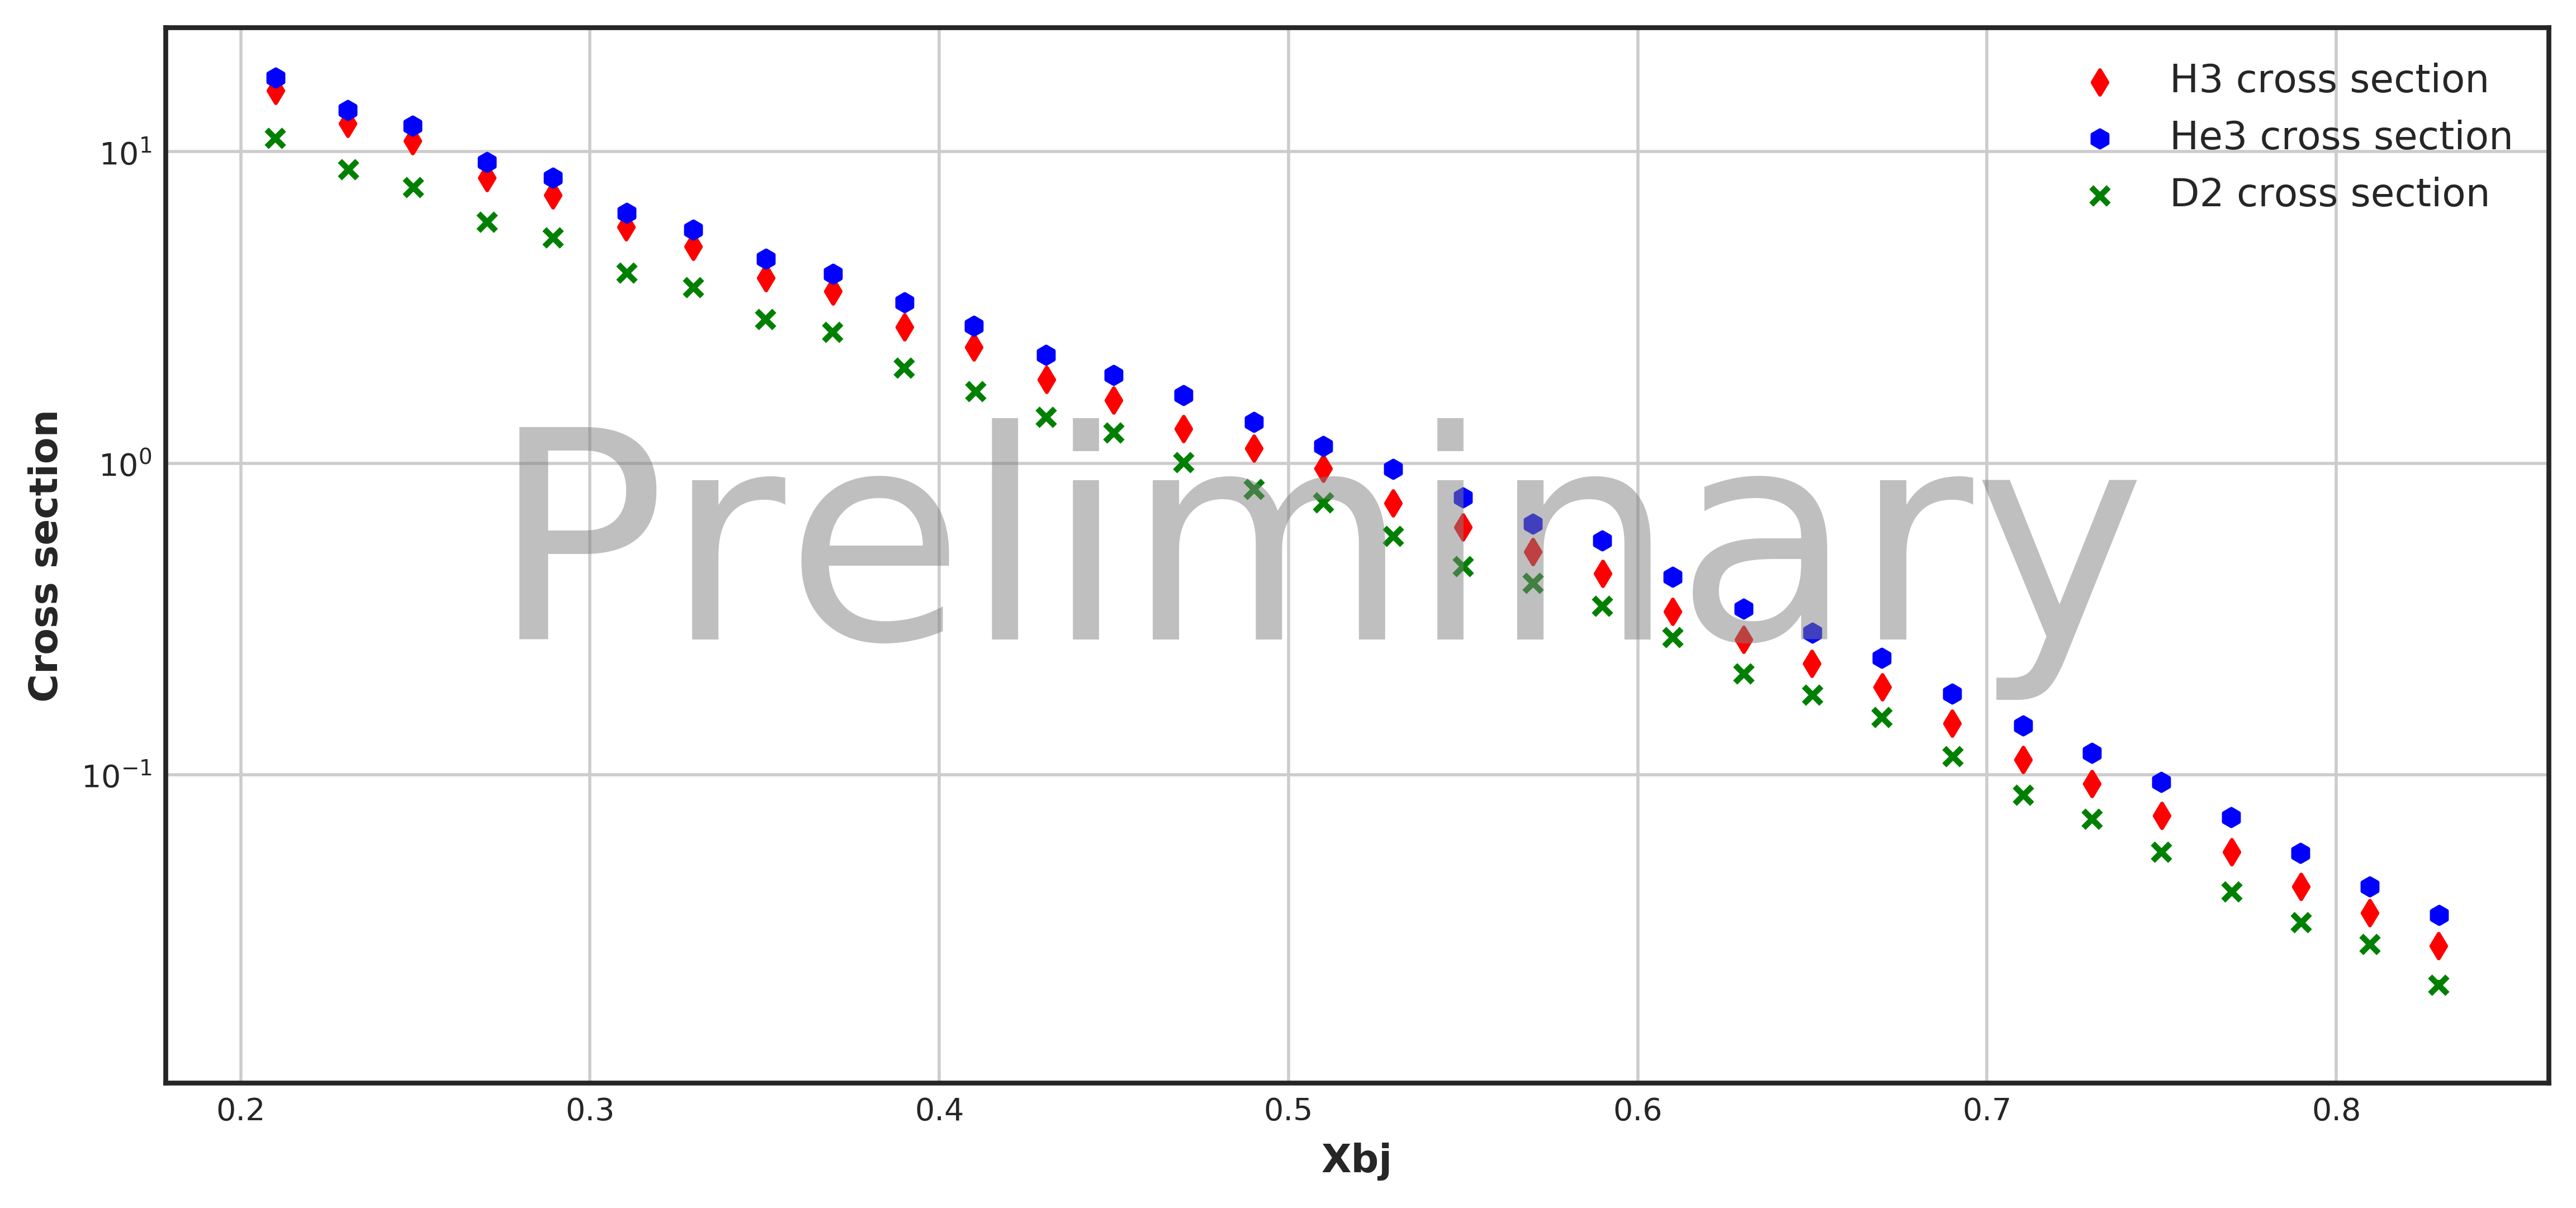

In [35]:
newfig = plt.figure(dpi=500,figsize=(11,5))
axis = newfig.add_subplot(1,1,1)
H3_full.plot(ax=axis,y="Sigma_Born_C",x='Xbj',yerr='Sig_Born_err',c='r',marker='d',kind="scatter",label="H3 cross section" )
He3_full.plot(ax=axis,y="Sigma_Born_C",x='Xbj',yerr='Sig_Born_err',c='b',marker='h',kind="scatter",label="He3 cross section" )
D2_full.plot(ax=axis,y="Sigma_Born_C",x='Xbj',yerr='Sig_Born_err',c='g',marker='x',kind="scatter",label="D2 cross section" )
axis.grid(True)
axis.set_yscale("log")
axis.set_ylabel("Cross section")

newfig.text(0.5, 0.5, 'Preliminary',
         fontsize=75, color='gray',
         ha='center', va='center', alpha=0.5)

newfig.savefig('images/{}{}bins/multisigma.png'.format(cuttype,bins),bbox_inches='tight')
newfig.savefig('images/{}{}bins/multisigma.pdf'.format(cuttype,bins),bbox_inches='tight')
newfig.savefig('images/{}{}bins/multisigma.eps'.format(cuttype,bins),bbox_inches='tight')
newfig.savefig('/home/jbane/latex_shows/images/multisigma.pdf'.format(cuttype,bins),bbox_inches='tight')




start second loop
1


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=5.205819 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[74.71646108  1.74802989  0.          0.        ]
 [ 0.         60.17538884 22.12119307  0.        ]
 [ 0.         13.6514183  51.13753442 62.00506449]
 [ 0.          0.         37.46715965 46.15282505]]

0 C12_kin1
2


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=5.265507 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=1.507927 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[58.83759991  2.20531289  0.          0.          0.        ]
 [ 0.         49.34295822  4.29687925  0.          0.        ]
 [ 0.          0.         40.44924898  4.04759739  0.        ]
 [ 0.          0.         15.29823781 34.54114059 40.77095956]
 [ 0.          0.          0.         25.83775837 31.04768306]]

1 C12_kin2
3


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=1.537332 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=51,54 m=2500 fp=0.588362 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[39.47082526  0.          0.          0.          0.        ]
 [15.04553687 33.38058804  8.36434524  0.          0.        ]
 [ 0.          2.55757546 27.67008441 19.11300415  0.        ]
 [ 0.          0.         10.75532963 23.62503912 25.75882176]
 [ 0.          0.          0.         17.24919611 20.90536606]]

2 C12_kin3
4


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.167851 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))



[[27.07446552  0.          0.          0.          0.        ]
 [ 0.         22.96887266  0.43827259  0.          0.        ]
 [ 0.         12.01031166 19.11748444  9.90094231  0.        ]
 [ 0.          0.         14.50936678 16.32266852 18.47719722]
 [ 0.          0.          0.         12.54272066 14.36789824]]

3 C12_kin4
5


/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=48,57 m=2500 fp=0.162644 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=50,55 m=2500 fp=0.062421 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/jbane/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable c


[[18.81339951 18.09083793  0.          0.          0.        ]
 [ 6.31883683 15.96349874  2.33614828  0.          0.        ]
 [ 0.         11.49975281 13.30431262  9.2172936   0.        ]
 [ 0.          0.          8.79974729 11.33026764 11.51386978]
 [ 0.          0.          0.          8.898625    9.91987908]]

4 C12_kin5
[<matplotlib.collections.PathCollection object at 0x7efdf1fbc588>, <matplotlib.collections.PathCollection object at 0x7efdf22ec080>] ['Monte Carlo', 'Data ']


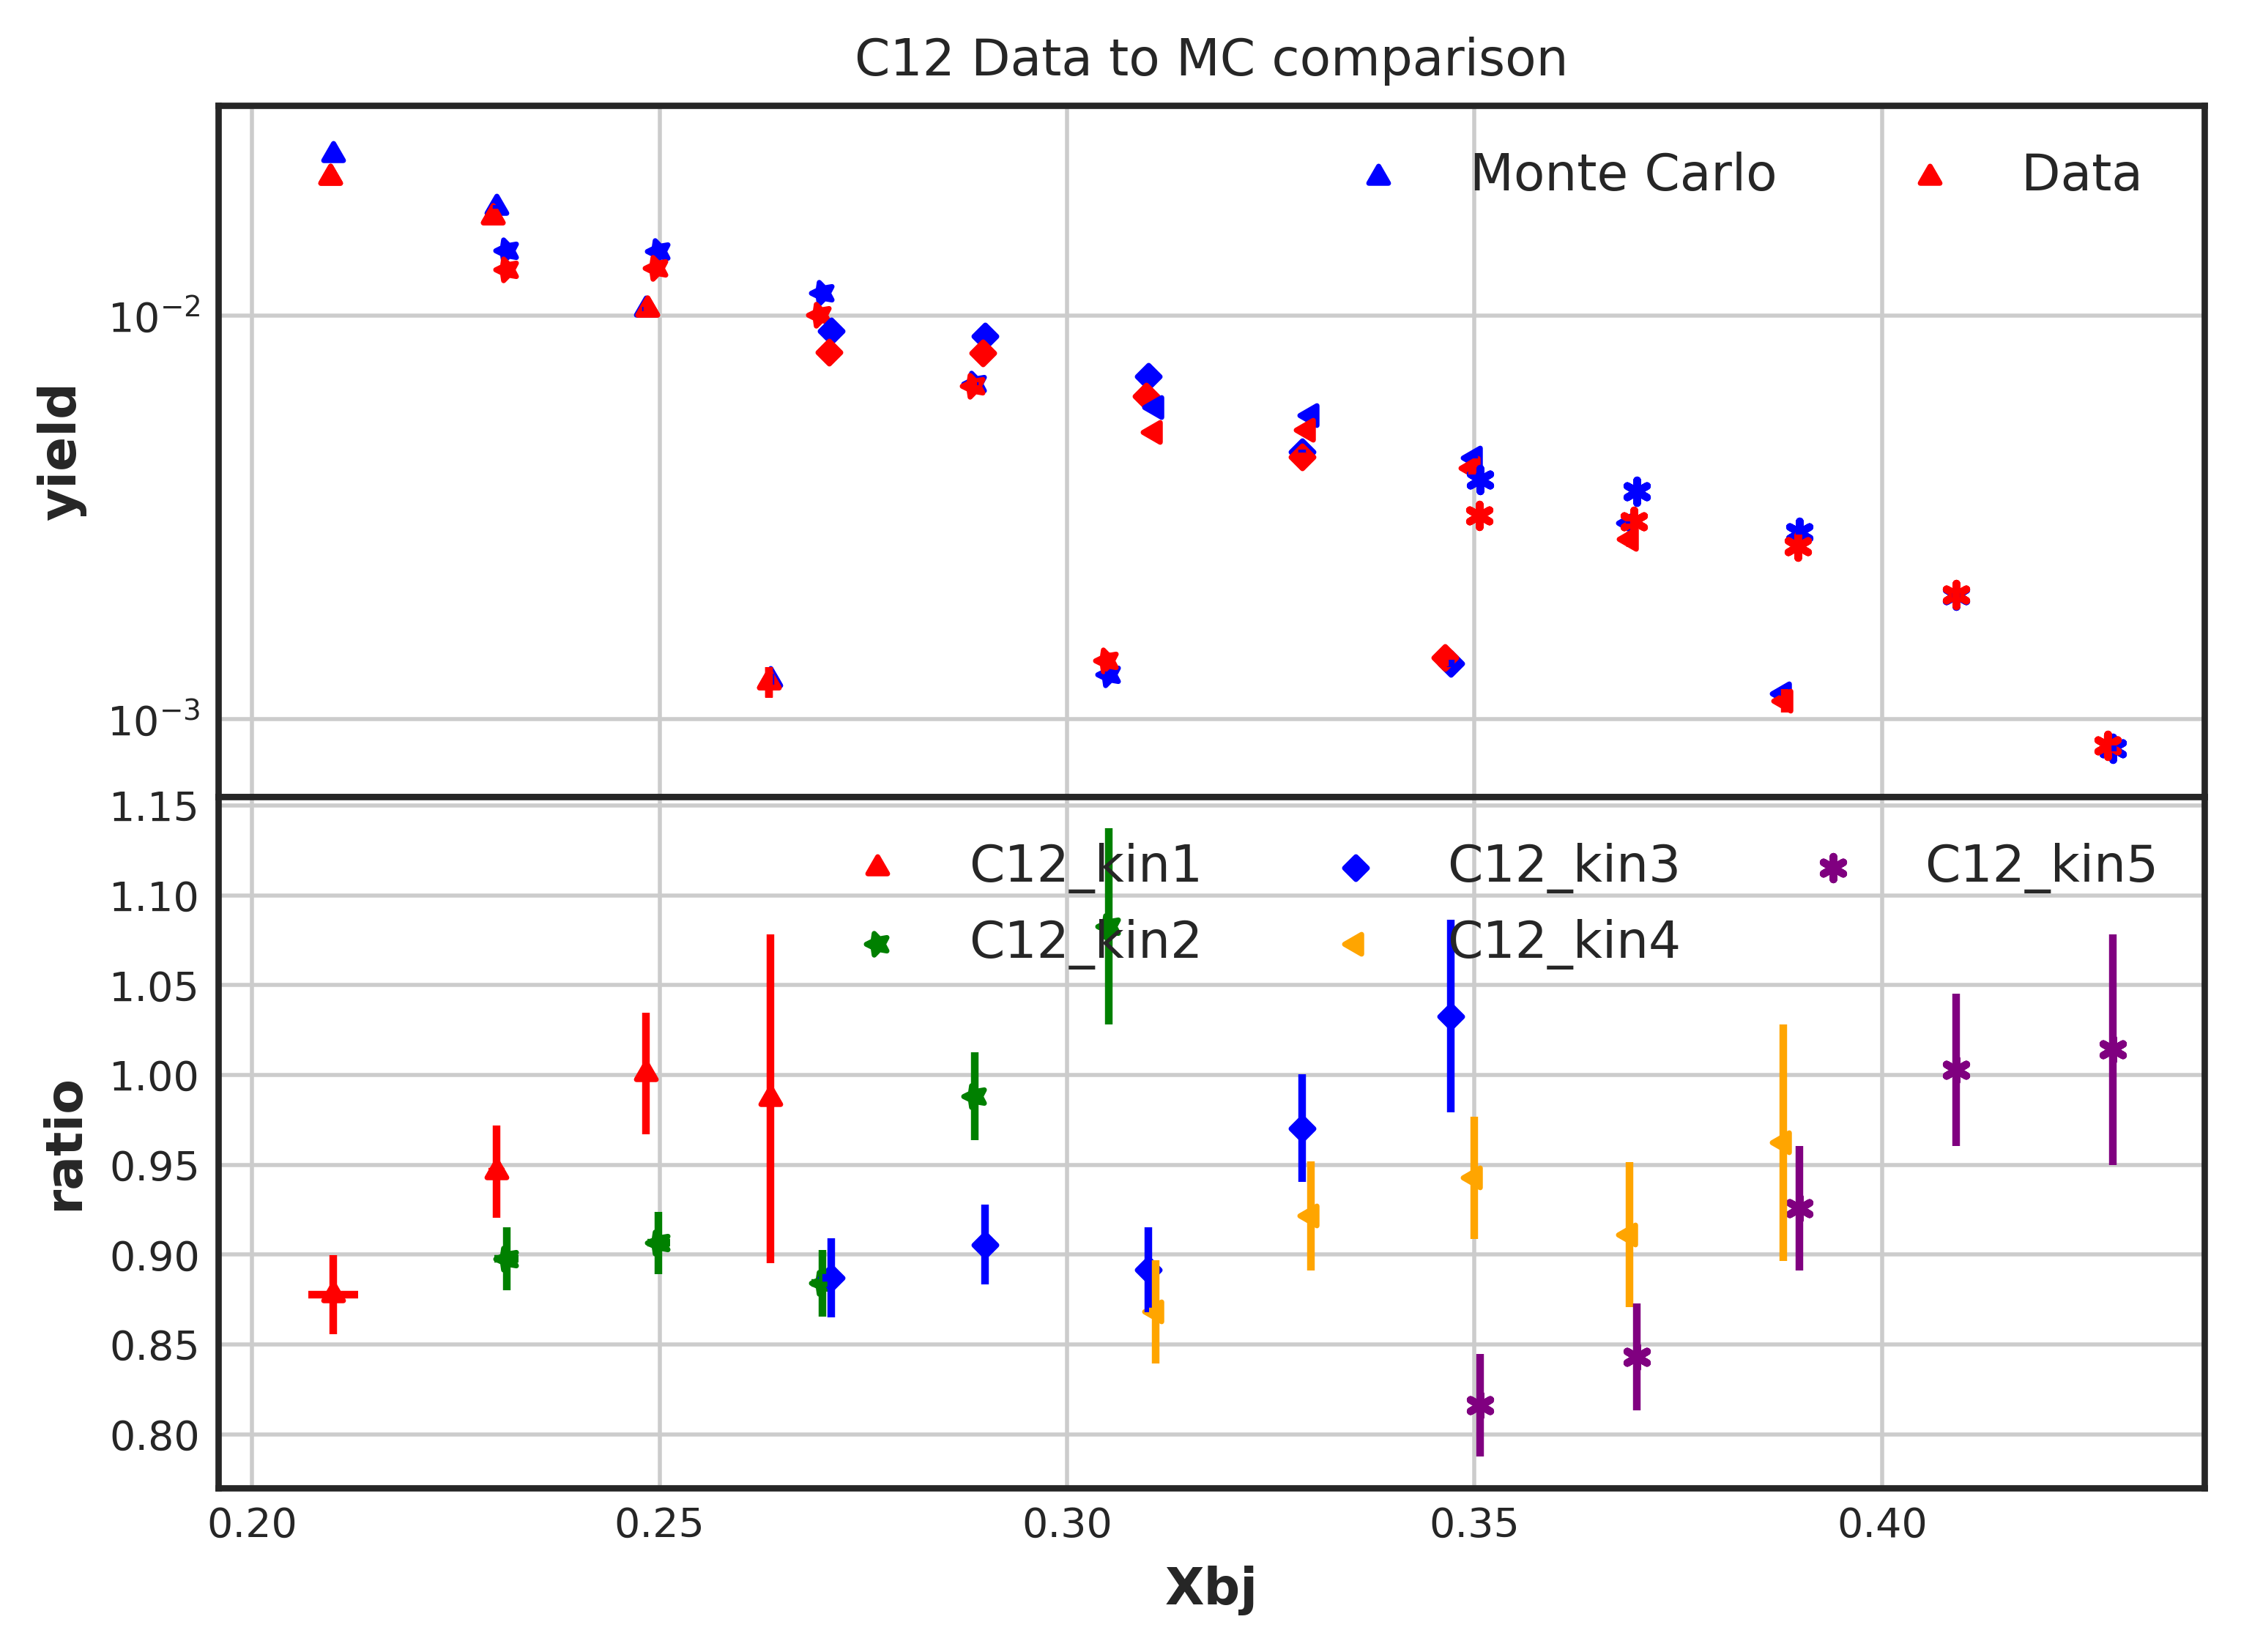

In [56]:
C12_ratios={} 
cuttype="tightcut/"
bins=50
max_kin=5
C12_ratios,kinsC12,figC12 = all_tgt("C12",bins)

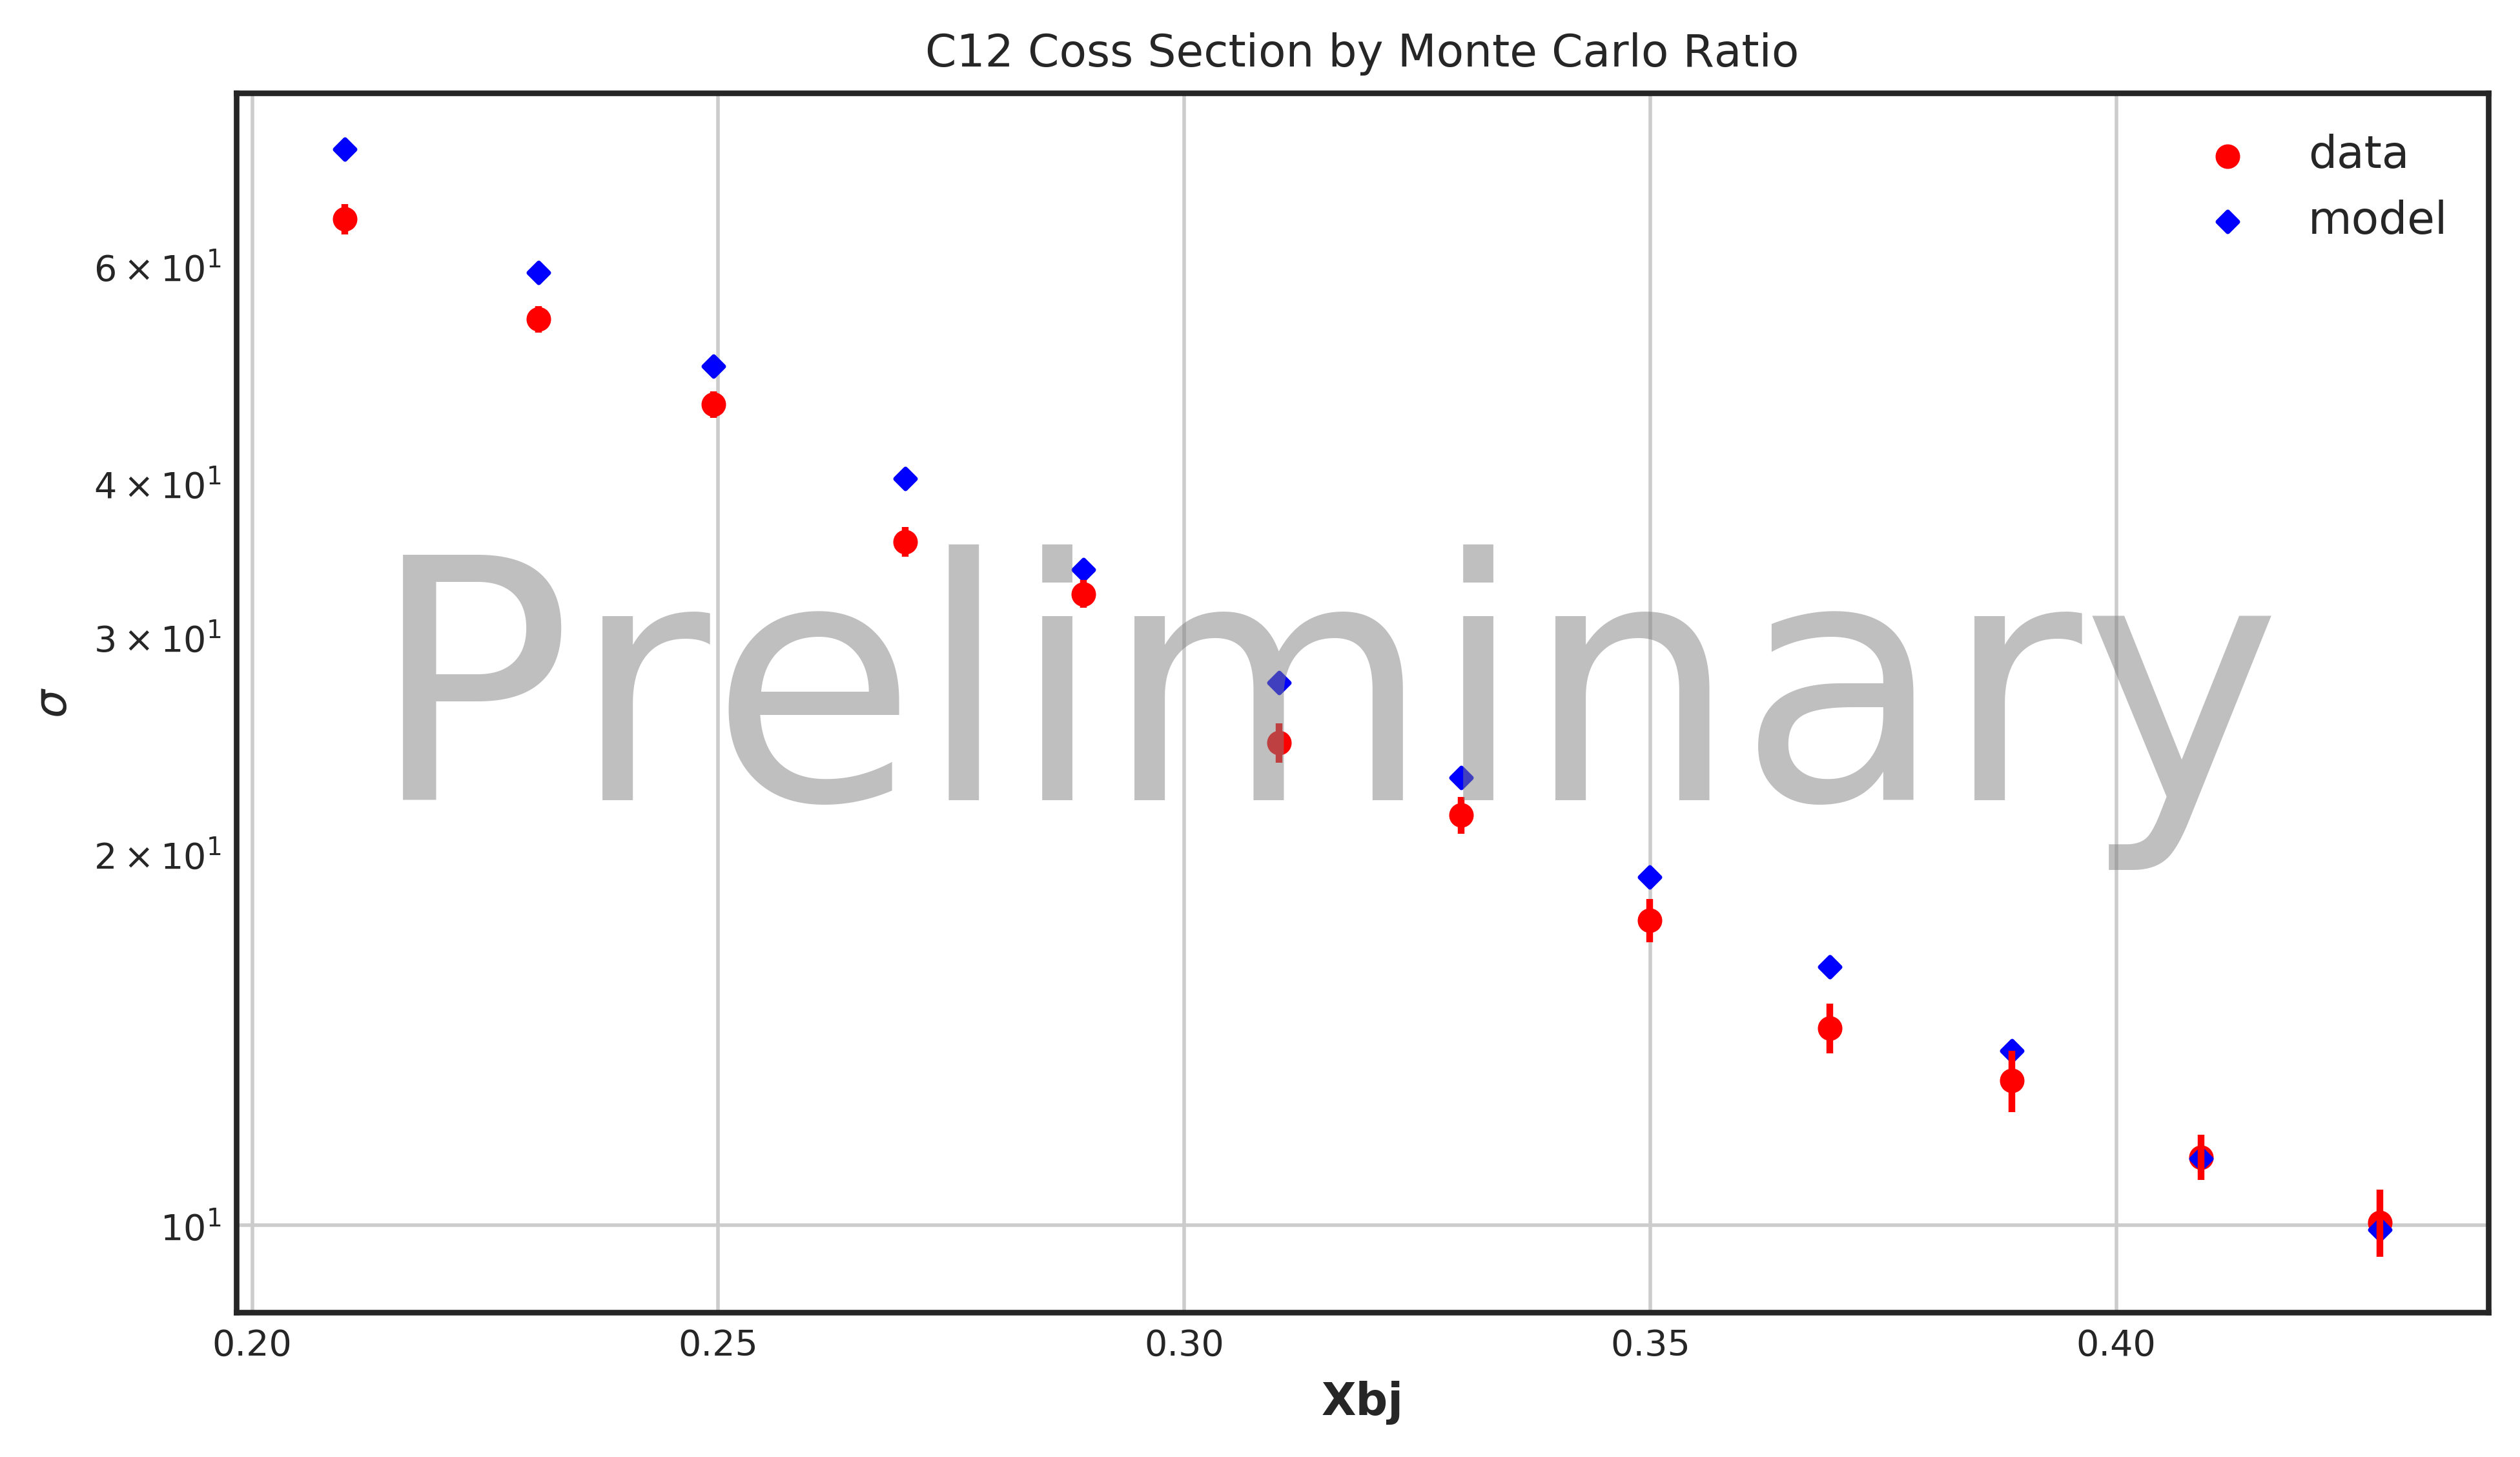

In [57]:
C12_full =together("C12",C12_ratios,bins)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

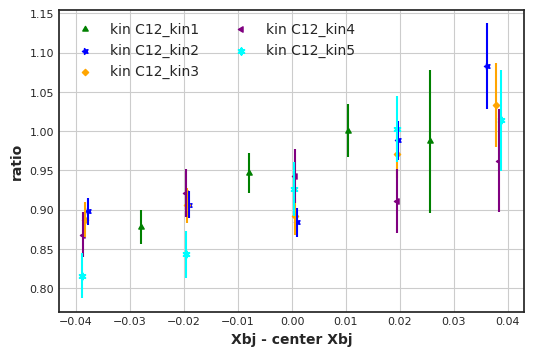

In [58]:
kincenteral(C12_ratios,kinsC12)

In [17]:
SQLF.SQLRuns("C12","3","1st")

select run_number from MARATHONrunlist where (kinematic = "3") and target="Carbon" order by run_number asc


{0: 1279, 1: 1280}

C12_ratios[1]

In [78]:
C12_ratios[0]['Ne']/C12_ratios[0]['Yield']/(25.0/1000000)/1000


10    18564.061247
11    23404.060679
12    28034.860404
13    31462.212704
dtype: float64

In [ ]:
a=[]
for i in range( len(C12_ratios)) :
    a.append(C12_ratios[i][['ratio','new_x','ratio_err']])
b=pd.concat(a)
b

In [ ]:
from sklearn import datasets, linear_model
x=b['new_x']
y=b['ratio']
yerr=b['ratio_err']

length=len(x)
x = x.values.reshape(length, 1)
y = y.values.reshape(length, 1)
yerr = yerr.values.reshape(length, 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.errorbar(x, y,yerr, color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [71]:
C12_ratios[0][['data_Y',]]

,data_Y
10,0.022006
11,0.017585
12,0.010379
13,0.001240
